# Contact
Created by: Ania Supady <p/>
Date:       09/2022 <p/>
>www.linkedin.com/in/aniasupady <p/>
>ania.b.supady@gmail.com

--------------------------------------------------------------------------------

# The Model Validation Report

--------------------------------------------------------------------------------



# 1. Executive Summary

The purpose of this report is for Model Risk Management (hereafter, MRM) to provide comprehensive guidance and effective challenge for model risk to the First Line of Defence and model owner regarding INV-001 "Credit Card Fraud" model which was designed to detect fraud in credit card transactions.


Following elements were considered for the report:


1. Model purpose and use
2. Model Risk score / tier assessment
3. Evaluation of conceptual soundness, including developmental evidence
4. Ongoing monitoring, including process verification and benchmarking
5. Outcomes analysis, including back-testing

# Model Purpose and Use

MRM assessed through the its review that the INV-001 "Credit Card Fraud" model is trained on a credit card transaction dataset using XGBoost algorithm to prevent transaction fraud. The model output is a probability and any transaction that has probability>0.5 will be rejected due to fraud risk.

# Model Risk Assessment

The company's Board expression of appetite for model
risk is one of the crucial steps in robust model risk
management. Model risk appetite is
articulated in the form of appetite statements and
of risk tolerance limits applied to effectively
monitored model risk metrics.<sup>[1](https://www.cambridge.org/core/journals/british-actuarial-journal/article/model-risk-illuminating-the-black-box/FD2FD9F9DD86CCB611B4ECEF1421A7AA)</sup>

MRM used following assumption to arrive at Model Risk score: "If the company loses 100% on the fraud transaction, and earns 2% transaction fee on any non-fraud transaction, what is the true risk to the business bottom line if model fails at being accurate at assessing fraudulent transactions?"

## Setting libraries

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import os
from datetime import datetime

import seaborn as sns
sns.set(color_codes=True)


import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from string import ascii_letters

import gdown

## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Get the CC data
import gdown
url = 'https://drive.google.com/uc?id=1GXx2h_EEiJqmXEs_dn67DEksOOuXRICe'
out_path = 'creditcard.xlsx'
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GXx2h_EEiJqmXEs_dn67DEksOOuXRICe
To: /content/creditcard.xlsx
100%|██████████| 1.79M/1.79M [00:00<00:00, 124MB/s]


'creditcard.xlsx'

In [ ]:
import pandas as pd
creditcard = pd.read_excel('creditcard.xlsx')
creditcard.head(10)

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,0,162183,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.471390,0.741141
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,NaN,-0.838932
2,0,26484,1937.66,1.457844,-0.899347,-6.059393,-1.784000,0.484257,-4.171672,1.195815
3,0,65751,320.05,-0.401365,-0.282106,-0.583587,1.345463,-1.038179,0.252497,-0.761357
4,0,137025,11.50,0.481656,-1.568433,3.699527,-0.296621,0.679977,-0.455964,0.534602
5,0,153446,50.00,-0.460557,-0.181962,0.100726,0.140934,-1.041333,-1.231973,-0.473974
6,0,134293,36.41,0.347716,-0.722340,-1.705423,-0.279583,0.499024,1.490258,-0.639360
7,0,159424,2.69,-0.366225,-0.007410,-0.022027,-0.174519,0.197820,0.031020,-0.581228
8,0,137894,213.77,-0.435890,0.948091,0.356405,-0.375145,-0.458142,0.360064,0.239402
9,0,70656,9.99,0.907651,-0.400754,-0.096516,-1.224589,0.068819,-0.417177,0.587596


In [ ]:
creditcard.info()

# Read Files and Column Explantion
# Class: Model target, 1 means it's a credit card fraud, otherwise 0
# Time: Seconds elapsed between each transaction and the first transaction in the dataset
# Amount: Credit card transaction amount
# featuer_1-featuer_7: other model inputs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14708 entries, 0 to 14707
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Class      14708 non-null  int64  
 1   Time       14708 non-null  int64  
 2   Amount     14708 non-null  float64
 3   feature_1  14708 non-null  float64
 4   feature_2  14708 non-null  float64
 5   feature_3  14708 non-null  float64
 6   feature_4  14708 non-null  float64
 7   feature_5  14708 non-null  float64
 8   feature_6  12377 non-null  float64
 9   feature_7  14708 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.1 MB


In [ ]:
total = creditcard.isnull().sum().sort_values(ascending = False)
percent = (creditcard.isnull().sum()/creditcard.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,feature_6,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7
Total,2331.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,15.848518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fraud Count

In [ ]:
df=creditcard.copy()
print(df.shape)

(14708, 10)


In [ ]:
t=df['Class'].value_counts() / len(df['Class'])
t

0    0.966549
1    0.033451
Name: Class, dtype: float64

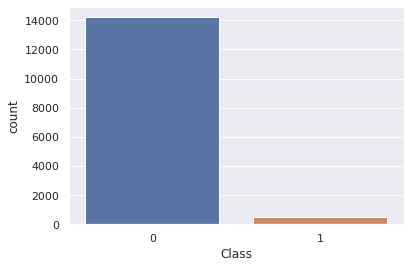

In [ ]:
sns.countplot(x=df['Class'])

In [ ]:
df['counter'] = 1
df.head()
TransbyClass = pd.concat([df.groupby("Class")["counter"].sum(),df.groupby("Class")["Amount"].sum(),df.groupby("Class")["Amount"].mean()],axis=1)
TransbyClass.columns = ["Frequency", "SumAmount","MeanAmount"]
TransbyClass.head()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
0,0,162183,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.471390,0.741141,1
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,NaN,-0.838932,1
2,0,26484,1937.66,1.457844,-0.899347,-6.059393,-1.784000,0.484257,-4.171672,1.195815,1
3,0,65751,320.05,-0.401365,-0.282106,-0.583587,1.345463,-1.038179,0.252497,-0.761357,1
4,0,137025,11.50,0.481656,-1.568433,3.699527,-0.296621,0.679977,-0.455964,0.534602,1


,Frequency,SumAmount,MeanAmount
Class,,,
0,14216,1171038.96,82.374716
1,492,59474.75,120.883638


In [ ]:
pd.crosstab(df['counter'], df['Class'])

Class,0,1
counter,,
1,14216,492


### MRM Assessment

MRM veryfied through the assessment above, that the fraud is a rare instance. The data contains 14,708 transactions and fraud only took place for 3.3451 % of transactions, while remaining 96.6549 % where not identified as fraud.

## Profit and Loss

### Profit

In [ ]:
# selecting rows based on condition "Profit"
noFraud_df = df[df['Class'] == 0]

noFraud_df['counter'] = 1
noFraud_df['Profit'] = noFraud_df['Amount'] *0.02

noFraud_df['abs_Amount'] = abs(noFraud_df['Amount'])

noFraud_df['abs_Profit'] = abs(noFraud_df['Amount']) *0.02

TransbyTimeProfit = pd.concat([noFraud_df.groupby("Time")["counter"].sum(),
                         noFraud_df.groupby("Time")["Amount"].sum(),
                         noFraud_df.groupby("Time")["abs_Amount"].sum(),
                         noFraud_df.groupby("Time")["Profit"].sum(),
                         noFraud_df.groupby("Time")["abs_Profit"].sum()]
                         ,axis=1)

TransbyTimeProfit.columns = ["SumFrequency", "SumAmount", "Sum_abs_Amount", "SumProfit", "Sum_abs_Profit"]


TransbyTimeProfit['Fraud'] = 0
TransbyTimeProfit.sort_values("SumAmount")

,SumFrequency,SumAmount,Sum_abs_Amount,SumProfit,Sum_abs_Profit,Fraud
Time,,,,,,
35021,1,-2130.63,2130.63,-42.6126,42.6126,0
76304,1,-1532.38,1532.38,-30.6476,30.6476,0
130198,2,-1230.00,1232.00,-24.6000,24.6400,0
38983,1,-998.00,998.00,-19.9600,19.9600,0
44772,1,-930.92,930.92,-18.6184,18.6184,0
...,...,...,...,...,...,...
146271,1,4290.00,4290.00,85.8000,85.8000,0
38721,1,4338.25,4338.25,86.7650,86.7650,0
53394,1,4652.24,4652.24,93.0448,93.0448,0


numpy.ndarray

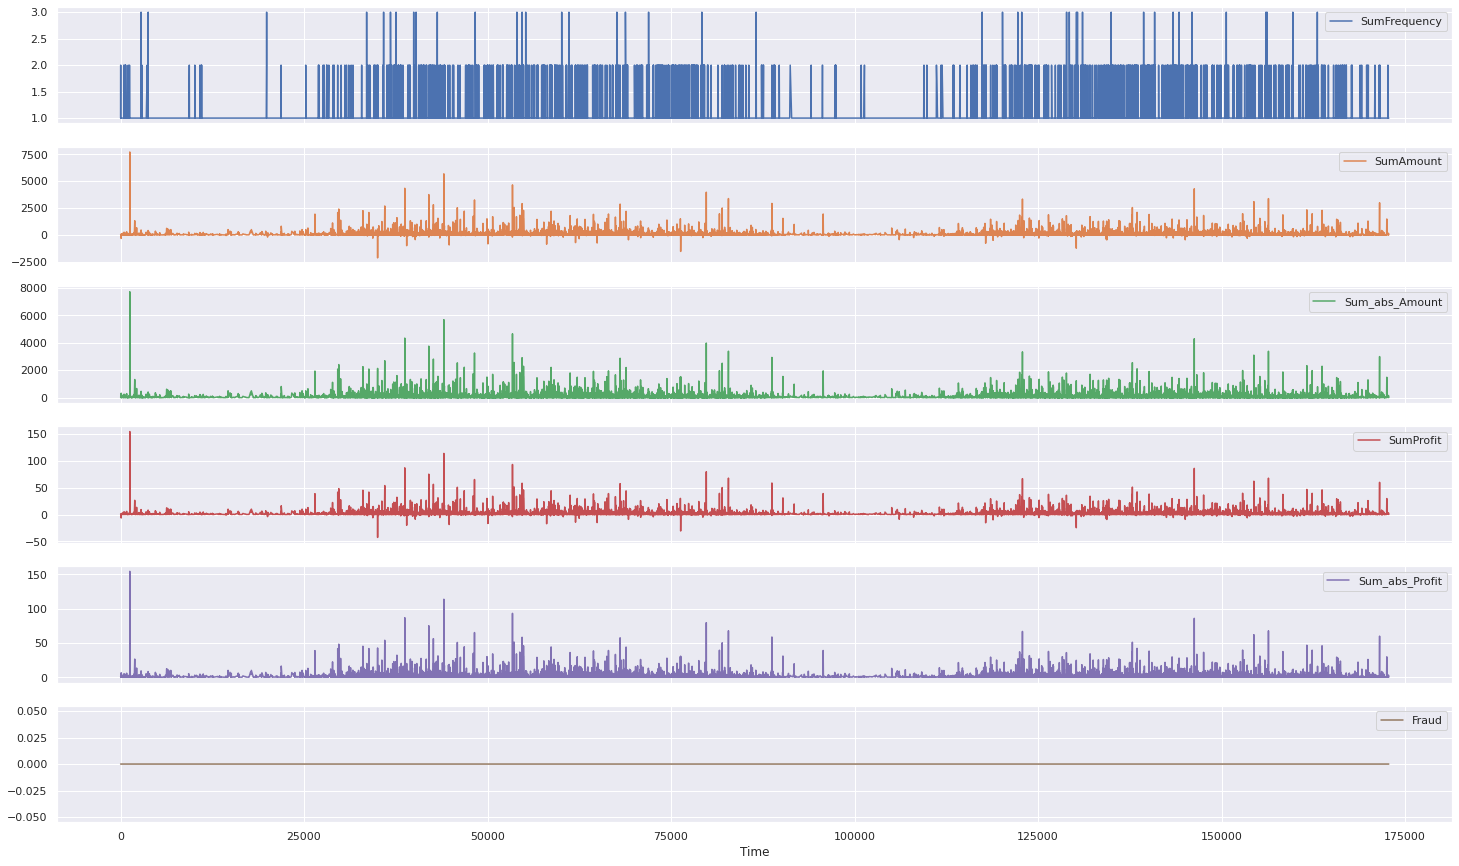

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
axes = TransbyTimeProfit.plot.line(subplots=True)
type(axes)

In [ ]:
noFraud_df['counter'] = 1
noFraud_df['Profit'] = noFraud_df['Amount'] *0.02

noFraud_df['abs_Amount'] = abs(noFraud_df['Amount'])

noFraud_df['abs_Profit'] = abs(noFraud_df['Amount']) *0.02

TransbyClassProfit = pd.concat([noFraud_df.groupby("Class")["counter"].sum(),
                         noFraud_df.groupby("Class")["Amount"].sum(),
                         noFraud_df.groupby("Class")["abs_Amount"].sum(),
                         noFraud_df.groupby("Class")["Profit"].sum(),
                         noFraud_df.groupby("Class")["abs_Profit"].sum()]
                         ,axis=1)

TransbyClassProfit.columns = ["SumFrequency", "SumAmount", "Sum_abs_Amount", "SumProfit", "Sum_abs_Profit"]


TransbyClassProfit['Fraud'] = 0
pd.options.display.float_format = "{:,.2f}".format
TransbyClassProfit

,SumFrequency,SumAmount,Sum_abs_Amount,SumProfit,Sum_abs_Profit,Fraud
Class,,,,,,
0,14216,"1,171,038.96","1,231,455.90","23,420.78","24,629.12",0


### Loss

In [ ]:
# selecting rows based on condition "Loss"
Fraud_df = df[df['Class'] == 1]


Fraud_df['counter'] = 1
Fraud_df['Loss'] = Fraud_df['Amount'] *1

Fraud_df['abs_Amount'] = abs(Fraud_df['Amount'])

Fraud_df['abs_Loss'] = abs(Fraud_df['Loss'])

TransbyTimeLoss = pd.concat([Fraud_df.groupby("Time")["counter"].sum(),
                         Fraud_df.groupby("Time")["Amount"].sum(),
                         Fraud_df.groupby("Time")["abs_Amount"].sum(),
                         Fraud_df.groupby("Time")["Loss"].sum(),
                         Fraud_df.groupby("Time")["abs_Loss"].sum()]
                         ,axis=1)

TransbyTimeLoss.columns = ["SumFrequency", "SumAmount", "Sum_abs_Amount", "SumLoss", "Sum_abs_Loss"]


TransbyTimeLoss['Fraud'] = 0
TransbyTimeLoss.sort_values("SumAmount")

,SumFrequency,SumAmount,Sum_abs_Amount,SumLoss,Sum_abs_Loss,Fraud
Time,,,,,,
102542,1,-2.28,2.28,-2.28,2.28,0
103808,1,-2.27,2.27,-2.27,2.27,0
142409,1,-2.00,2.00,-2.00,2.00,0
21662,1,-1.00,1.00,-1.00,1.00,0
13323,1,-1.00,1.00,-1.00,1.00,0
...,...,...,...,...,...,...
59011,1,"1,389.56","1,389.56","1,389.56","1,389.56",0
62467,1,"1,402.16","1,402.16","1,402.16","1,402.16",0
154278,1,"1,504.93","1,504.93","1,504.93","1,504.93",0


numpy.ndarray

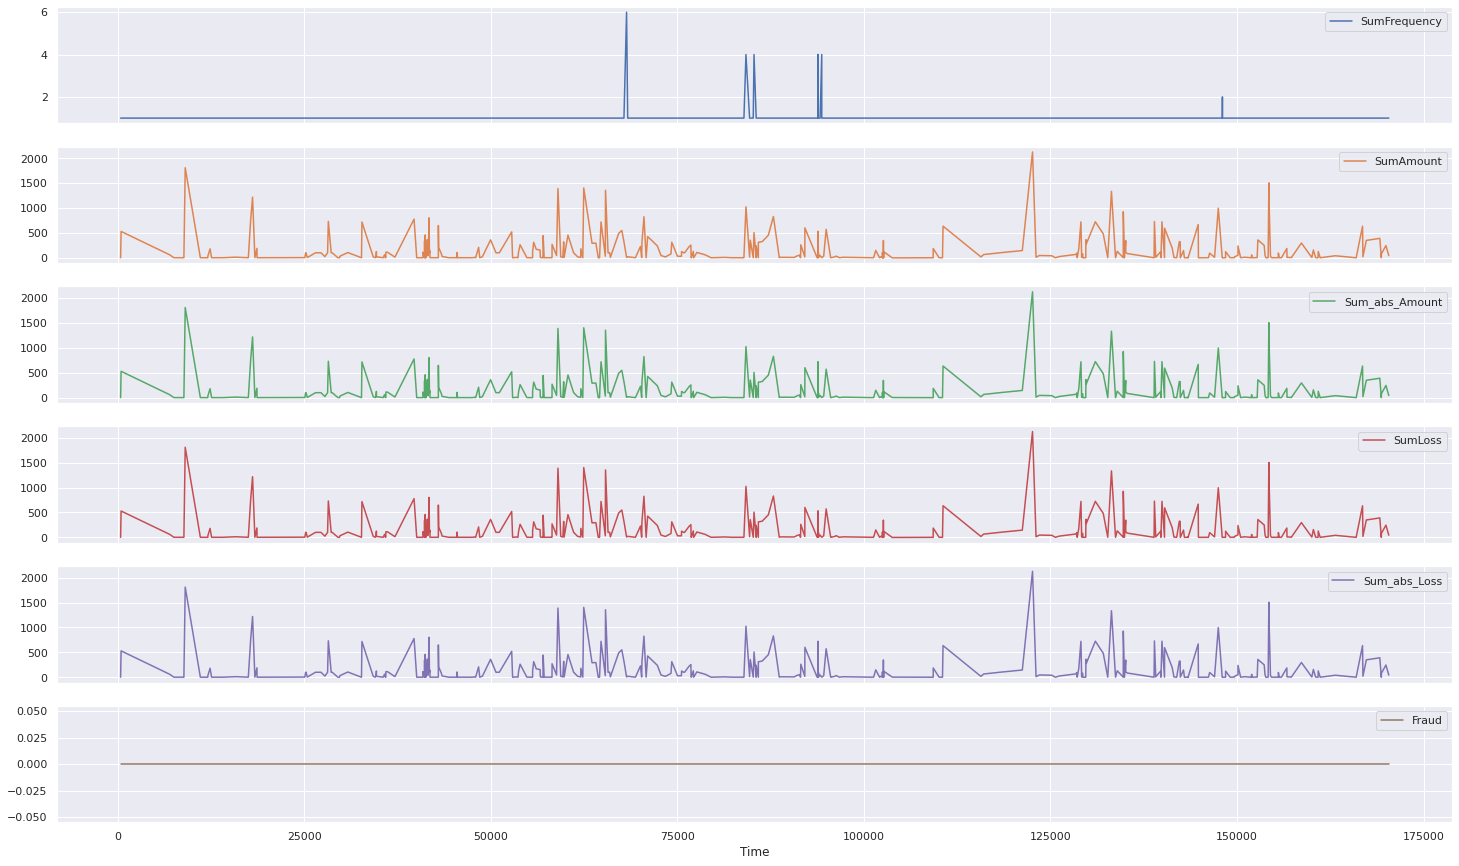

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
axes = TransbyTimeLoss.plot.line(subplots=True)
type(axes)

In [ ]:
# selecting rows based on condition "Loss"
Fraud_df = df[df['Class'] == 1]


Fraud_df['counter'] = 1
Fraud_df['Loss'] = Fraud_df['Amount'] *1
Fraud_df['fee_Loss'] = Fraud_df['Amount'] *0.02

Fraud_df['abs_Amount'] = abs(Fraud_df['Amount'])

Fraud_df['abs_Loss'] = abs(Fraud_df['Loss'])
Fraud_df['abs_fee_Loss'] = abs(Fraud_df['fee_Loss'])

TransbyClassLoss = pd.concat([Fraud_df.groupby("Class")["counter"].sum(),
                         Fraud_df.groupby("Class")["Amount"].sum(),
                         Fraud_df.groupby("Class")["abs_Amount"].sum(),
                         Fraud_df.groupby("Class")["Loss"].sum(),
                         Fraud_df.groupby("Class")["abs_Loss"].sum(),
                         Fraud_df.groupby("Class")["fee_Loss"].sum(),
                         Fraud_df.groupby("Class")["abs_fee_Loss"].sum()]
                         ,axis=1)

TransbyClassLoss.columns = ["SumFrequency", "SumAmount", "Sum_abs_Amount", "SumLoss", "Sum_abs_Loss", "fee_Loss", "abs_fee_Loss"]



pd.options.display.float_format = "{:,.2f}".format

TransbyClassLoss['Fraud'] = 0

TransbyClassLoss['Total_Loss'] = TransbyClassLoss['Sum_abs_Loss'] + TransbyClassLoss['abs_fee_Loss']


TransbyClassLoss.sort_values("SumAmount")

,SumFrequency,SumAmount,Sum_abs_Amount,SumLoss,Sum_abs_Loss,fee_Loss,abs_fee_Loss,Fraud,Total_Loss
Class,,,,,,,,,
1,492,"59,474.75","60,127.97","59,474.75","60,127.97","1,189.50","1,202.56",0,"61,330.53"


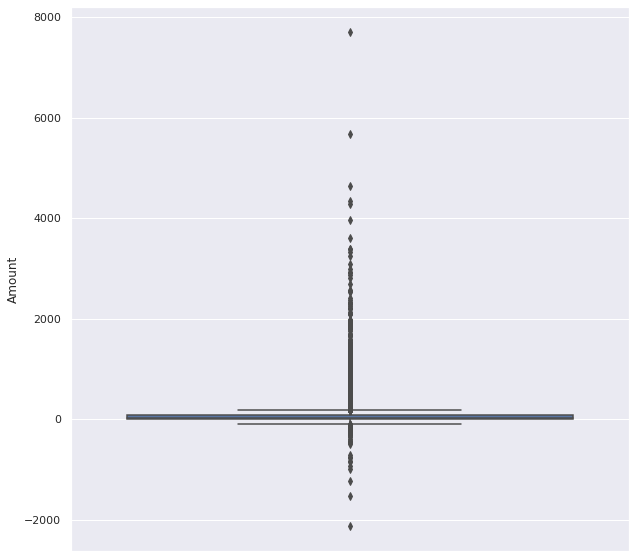

In [ ]:
fig = plt.figure(figsize =(10, 10))
t2=sns.boxplot(y='Amount', data=df)

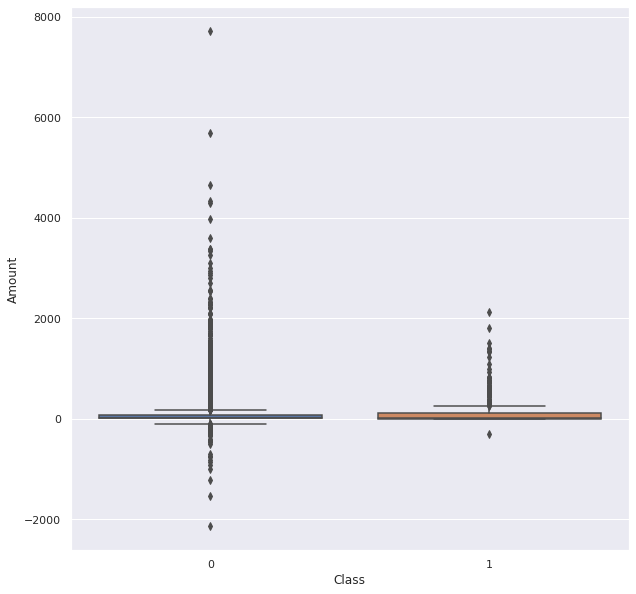

In [ ]:
fig = plt.figure(figsize =(10, 10))
t=sns.boxplot(x='Class', y='Amount', data=df)

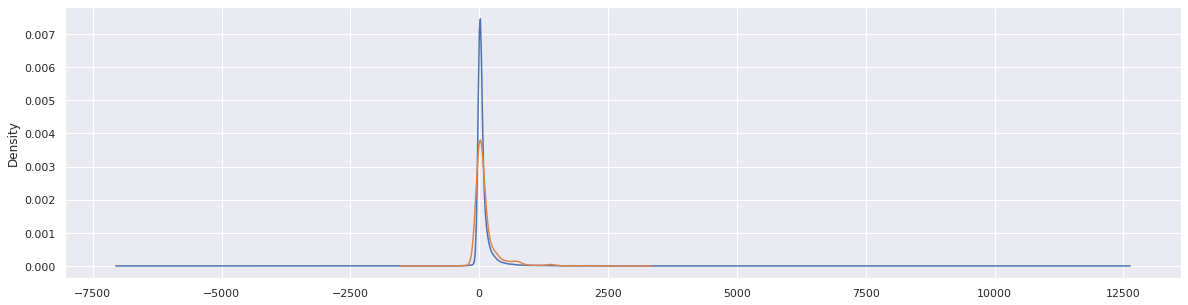

In [ ]:
fig = plt.figure(figsize =(20, 5))
fig=df.groupby("Class").Amount.plot(kind='kde')

#### Charge-back

A chargeback is a return of money to a payer of a transaction, especially a credit card transaction. Most commonly the payer is a consumer. The chargeback reverses a money transfer from the consumer's bank account, line of credit, or credit card. [Wikipedia](https://en.wikipedia.org/wiki/Chargeback)


MRM decided that the evaluation if the negative transaction amount in the data is due to the fraudulent charge-backs is needed. Below is the work flow:

#### Split data by "Amount" condition

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,83.00,104.00,104.00
mean,0.26,"95,942.86",0.00,-1.40,-1.83,0.02,-0.63,0.16,-0.85,0.19,1.00
std,0.44,"47,432.84",0.00,3.98,4.26,2.56,2.21,1.06,2.76,1.07,0.00
min,0.00,406.00,0.00,-20.58,-13.78,-18.00,-11.29,-3.13,-12.89,-1.13,1.00
25%,0.00,"53,808.75",0.00,-0.85,-1.62,-0.56,-0.68,-0.38,-0.58,-0.33,1.00
50%,0.00,"99,876.00",0.00,-0.22,-0.05,0.13,-0.13,0.23,-0.04,0.12,1.00
75%,1.00,"139,712.75",0.00,0.21,0.60,0.92,0.46,0.88,0.46,0.54,1.00
max,1.00,"166,733.00",0.00,6.44,2.27,9.88,2.95,2.87,3.04,8.36,1.00


0   0.74
1   0.26
Name: Class, dtype: float64

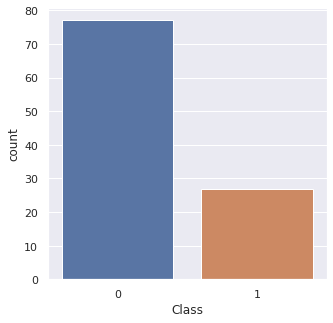

In [ ]:
# selecting rows based on condition
fig = plt.figure(figsize =(5, 5))
zero_df = df[df['Amount'] == 0]
zero_df.describe()

r=sns.countplot(x=zero_df['Class'])
t=zero_df['Class'].value_counts() / len(zero_df['Class'])
t

In [ ]:
# selecting rows based on condition
negative_df = df[df['Amount'] < 0]
negative_df.describe()

# selecting rows based on condition
positive_df = df[df['Amount'] > 0]
positive_df.describe()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,353.00,353.00,353.00,353.00,353.00,353.00,353.00,353.00,0.00,353.00,353.00
mean,0.02,"98,696.25",-86.50,-0.17,-0.19,-0.07,-0.08,2.33,NaN,0.06,1.00
std,0.15,"46,422.90",203.67,1.72,1.87,1.57,1.31,0.32,NaN,0.72,0.00
min,0.00,93.00,"-2,130.63",-18.91,-18.05,-10.56,-12.66,2.00,NaN,-1.90,1.00
25%,0.00,"59,024.00",-81.87,-0.53,-0.51,-0.82,-0.44,2.10,NaN,-0.51,1.00
50%,0.00,"102,542.00",-19.99,-0.12,0.07,-0.08,0.06,2.23,NaN,0.08,1.00
75%,0.00,"142,133.00",-5.30,0.40,0.51,0.68,0.59,2.47,NaN,0.58,1.00
max,1.00,"171,869.00",-0.01,4.13,4.34,10.24,2.66,3.90,NaN,2.52,1.00


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,"14,251.00","14,251.00","14,251.00","14,251.00","14,251.00","14,251.00","14,251.00","14,251.00","12,294.00","14,251.00","14,251.00"
mean,0.03,"94,725.17",88.49,-0.20,-0.22,-0.10,-0.13,-0.06,-0.17,0.00,1.00
std,0.18,"47,367.72",235.34,1.87,1.67,1.75,1.31,0.94,1.67,0.75,0.00
min,0.00,12.00,0.01,-25.16,-19.21,-32.09,-14.13,-3.64,-24.59,-8.89,1.00
25%,0.00,"54,114.50",5.55,-0.51,-0.48,-0.71,-0.52,-0.70,-0.57,-0.54,1.00
50%,0.00,"85,428.00",22.08,-0.09,0.02,-0.08,0.04,-0.03,-0.11,0.00,1.00
75%,0.00,"139,111.00",80.00,0.39,0.47,0.59,0.51,0.62,0.44,0.53,1.00
max,1.00,"172,768.00","7,712.43",6.74,5.95,29.16,6.44,2.00,12.70,8.32,1.00


#### Put the negative/positive into lists

In [ ]:
# select a column as series and then convert it into a column
negative_Amount = negative_df['Amount'].to_list()
positive_Amount = positive_df['Amount'].to_list()

#### Check if identical

In [ ]:
# sorting both the lists
negative_Amount.sort()
positive_Amount.sort()

# using == to check if
# lists are equal
if negative_Amount == positive_Amount:
    print ("The lists are identical")
else :
    print ("The lists are not identical")

The lists are not identical


#### Check if in common

In [ ]:
#Defining function to check for common elements in two lists
def commonelems(x,y):
   common=0
   for value in x:
      if value in y:
         common=1
   if(not common):
      return ("The lists have no common elements")
   else:
     return ("The lists have common elements")

# In[24]:

#Checking two lists for common elements
print("Comparing list1 and list2:")
print(commonelems(negative_Amount,positive_Amount))
print("\n")

Comparing list1 and list2:
The lists have no common elements




### MRM Assessment

>Negative Amount
<p align="justify">MRM confirmed through the analysis above that the variable "Amount" ranges between positive and negative values. MRM would like to have better understanding of the meaning of negative values in investigating transaction fraud. Generally speaking, a negative value may mean a charge back, but given "negative valued" transaction would have a matching "positive valued" transaction. In data cleaning process, a step correctly identifying purpose and use of the variable "Amount" would be required.

After performing checks on positive and negative amounts, MRM confirmed that the positive and negative "Amounts" are not pairs, the two lists do not match. The data does not represent typical case of a charge back. Possible solution:


1.   Override negatives to positives and assume data was just recorded incorrectly,
2.   Model negatives and positives separatelly
3.   Limit data to only transaction amounts grater than zero,
</p>  

>Zero $ Amount

<p align="justify">Another interesting property of the variable "Amount" is that there are transactions of zero dollars. This must be a result of generating data for this task. During standard model validation, the replication of pulling data from database would be required along with business logic, completness, accuracy and correctness of recording variable "Amount".

>Conclusion

In conclusion, the valid transaction amount which is identifed as fraud and not charge back, needs to be of non-zero and non-negative value and be of an acceptable and allowed range under credit limit established under given line of business. MRM is requesting, that further investigation into variable "Amount" takes place and model is re-evaluated using correctly identified dependent variable.</p>

#### Totals and Averages

In [ ]:
TransbyClassProfit
TransbyClassLoss

,SumFrequency,SumAmount,Sum_abs_Amount,SumProfit,Sum_abs_Profit,Fraud
Class,,,,,,
0,14216,"1,171,038.96","1,231,455.90","23,420.78","24,629.12",0


,SumFrequency,SumAmount,Sum_abs_Amount,SumLoss,Sum_abs_Loss,fee_Loss,abs_fee_Loss,Fraud,Total_Loss
Class,,,,,,,,,
1,492,"59,474.75","60,127.97","59,474.75","60,127.97","1,189.50","1,202.56",0,"61,330.53"


In [ ]:
x= 61330.53/24629.12
x

2.490163270145259

In [ ]:
y=24629.12-61330.53
y

-36701.41

In [ ]:
df.describe()
noFraud_df.describe()
Fraud_df.describe()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,"14,708.00","14,708.00","14,708.00","14,708.00","14,708.00","14,708.00","14,708.00","14,708.00","12,377.00","14,708.00","14,708.00"
mean,0.03,"94,829.09",83.66,-0.21,-0.23,-0.10,-0.13,-0.00,-0.18,0.01,1.00
std,0.18,"47,346.55",235.42,1.90,1.71,1.75,1.32,1.00,1.68,0.75,0.00
min,0.00,12.00,"-2,130.63",-25.16,-19.21,-32.09,-14.13,-3.64,-24.59,-8.89,1.00
25%,0.00,"54,233.00",4.49,-0.51,-0.49,-0.71,-0.52,-0.68,-0.57,-0.54,1.00
50%,0.00,"85,805.50",20.00,-0.09,0.02,-0.08,0.04,-0.00,-0.11,0.01,1.00
75%,0.00,"139,157.50",76.67,0.39,0.47,0.60,0.51,0.68,0.44,0.53,1.00
max,1.00,"172,768.00","7,712.43",6.74,5.95,29.16,6.44,3.90,12.70,8.36,1.00


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter,Profit,abs_Amount,abs_Profit
count,"14,216.00","14,216.00","14,216.00","14,216.00","14,216.00","14,216.00","14,216.00","14,216.00","11,969.00","14,216.00","14,216.00","14,216.00","14,216.00","14,216.00"
mean,0.00,"95,316.46",82.37,0.01,0.01,0.01,0.01,0.00,0.01,0.01,1.00,1.65,86.62,1.73
std,0.00,"47,256.17",234.53,0.74,0.88,1.36,0.84,1.00,1.02,0.71,0.00,4.69,232.99,4.66
min,0.00,12.00,"-2,130.63",-15.57,-11.64,-32.09,-9.15,-3.64,-10.51,-5.72,1.00,-42.61,0.00,0.00
25%,0.00,"54,647.00",4.95,-0.48,-0.43,-0.67,-0.47,-0.68,-0.52,-0.54,1.00,0.10,5.76,0.12
50%,0.00,"86,367.50",20.00,-0.07,0.04,-0.06,0.07,0.00,-0.09,0.00,1.00,0.40,21.99,0.44
75%,0.00,"139,384.25",75.42,0.39,0.49,0.60,0.52,0.68,0.46,0.53,1.00,1.51,78.00,1.56
max,0.00,"172,768.00","7,712.43",6.54,5.95,29.16,6.44,3.90,12.70,3.57,1.00,154.25,"7,712.43",154.25


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter,Loss,fee_Loss,abs_Amount,abs_Loss,abs_fee_Loss
count,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,408.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00
mean,1.00,"80,746.81",120.88,-6.67,-6.97,-3.15,-4.14,-0.03,-5.63,0.01,1.00,120.88,2.42,122.21,122.21,2.44
std,0.00,"47,835.37",257.31,6.97,4.28,5.37,3.87,1.01,4.92,1.49,0.00,257.31,5.15,256.68,256.68,5.13
min,1.00,406.00,-316.06,-25.16,-19.21,-22.11,-14.13,-3.61,-24.59,-8.89,1.00,-316.06,-6.32,0.00,0.00,0.00
25%,1.00,"41,241.50",1.00,-11.95,-9.69,-4.79,-6.56,-0.70,-7.54,-0.53,1.00,1.00,0.02,1.00,1.00,0.02
50%,1.00,"75,568.50",9.17,-5.30,-6.73,-1.52,-3.55,-0.03,-4.57,0.05,1.00,9.17,0.18,9.25,9.25,0.18
75%,1.00,"128,483.00",105.08,-1.34,-4.28,0.21,-1.23,0.72,-2.44,0.62,1.00,105.08,2.10,105.89,105.89,2.12
max,1.00,"170,348.00","2,125.87",6.74,3.44,11.10,3.14,2.51,4.03,8.36,1.00,"2,125.87",42.52,"2,125.87","2,125.87",42.52


#### Monthly/Yearly Losses

numpy.ndarray

,Time,calc,calc_min,calc_hour,calc_day
count,"14,707.00","14,707.00","14,707.00","14,707.00","14,707.00"
mean,0.56,"52,352.63",872.54,14.54,0.61
std,"65,611.98","39,546.78",659.11,10.99,0.46
min,"-170,023.00",0.00,0.00,0.00,0.00
25%,"-45,680.50","17,297.50",288.29,4.80,0.20
50%,92.00,"45,222.00",753.70,12.56,0.52
75%,"44,739.50","83,135.00","1,385.58",23.09,0.96
max,"172,000.00","172,000.00","2,866.67",47.78,1.99


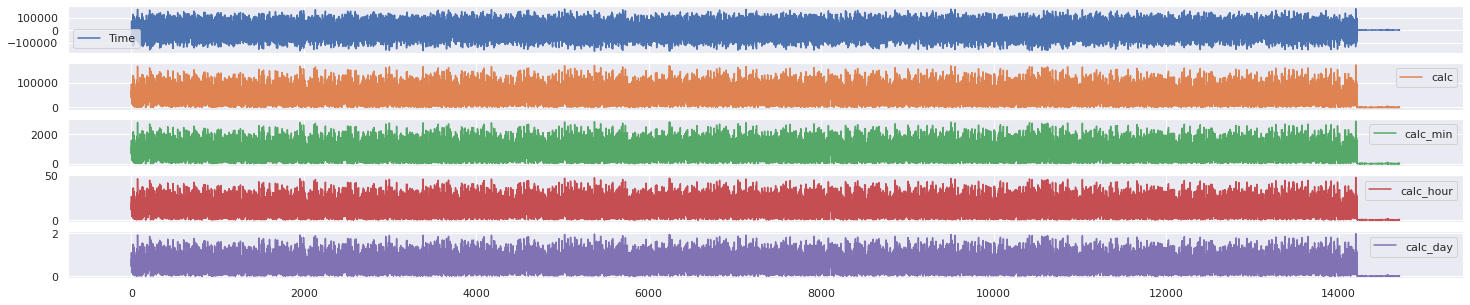

In [ ]:
# "Time: Seconds elapsed between each transaction and the first transaction in the dataset"

# If the above assumption holds, then all these transactions took place in approximatelly 2 days.
# If business operates as usual, and given data is representative of typycal daily transaction, then the calculated losses below would be multiplied by 15 to arrive at monthly losses,

# Approximate monthly losses= 919,957.95
# Approximate yearly losses= 11,039,495.399999999

diff = creditcard.Time.diff()
diff = pd.DataFrame(diff)
diff["calc"]=abs(diff["Time"])
diff["calc_min"]=diff["calc"]/60
diff["calc_hour"]=diff["calc"]/3600
diff["calc_day"]=diff["calc_hour"]/24

sns.set(rc={'figure.figsize':(25,5)})
axes = diff.plot.line(subplots=True)
type(axes)

diff.describe()

In [ ]:
monthly_losses = 61330.53*15
monthly_losses

919957.95

In [ ]:
yearly_losses=919957.95*12
yearly_losses

11039495.399999999

### Model Risk Assessment

Industry standard worldwide is to keep fraudulent credit card transactions at 1% or less.

Credit card fraud statistics: [1](https://mint.intuit.com/blog/planning/credit-card-fraud-statistics/#:~:text=The%20top%20five%20states%20with,21.), [2](https://shiftprocessing.com/credit-card-fraud-statistics/), evidence the rise of credit card fraud. By 2025, the United States is projected to reach $12.5 billion in card fraud losses.


Among 14,708 transactions in this data set, only 492 were fraudulent. We do not know if total transactions took place in 24 hours or in a month. Based on assessing the absolute difference between each next stransaction by differencing, MRM concluded that it is possible that these transactions took place within approximatelly two days.


The percent of fraudulent cases is at 3,3451% which is three times the industry standard.


Lets assume that the negative values are recorded as such by mistake, and the total absolute dollar amount for all non-fraudulent transactions can be calculated, then company would have made 2 % on 1,231,455.90, which amounts to 24,629.12.

If the company lost all the money on fraudulent transactions, and had to return them to the clients, then considering the same assumption as above, the absolute loss would be 60,127.97, and the not earned 2% fee 1,202.56 which totals $61,330.53

MRM assessed that the company would have lost 2.5 more money than it would have made on the fees for non-fraudulent transactions. The total amount lost would have been $36,701.41. The relativelly low dollar losses are driven by the fact that the average transaction value for all transactions is only 83 dollars with maximum transactin being around 8,000 dollars. The maximum fraudulent transaction in this data set is about 4 times lower than non-traudulent transaction. If the underlying distribution is not driven by credit limit but simply customer activity, such model would need to be monitored on ongoing basis. The information on credit limit would have to be incorporated to estimate expected credit loses at any point and time.

>Approximate monthly/yearly losses

Time variable assumption: "Time is the seconds elapsed between each transaction and the first transaction in the dataset"

If the above assumption holds, then all these transactions took place in approximatelly 2 days.

If business operates as usual, and given data is representative of typical daily transactions, then the calculated losses above would be multiplied by 15 to arrive at monthly losses.

* Approximate monthly losses =    $919,957.95

* Approximate yearly losses =  $11,039,495.39

>Based on the analysis above and industry standard research, MRM feels comfortable assessing the model as at least **Tier 2** model, having hight to moderate risk to the business.

# Model Development Data

MRM performed innitial assessment of the variable Amount under the "Profit/Loss" analysis.

This section will contain analysis of the independent variables considered for this model.

In [ ]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))
unique_values(df)

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
Total,14708,14708,14708,14708,14708,14708,14708,14708,12377,14708,14708
Uniques,2,13827,5822,14617,14617,14617,14617,14708,12306,14617,1


In [ ]:
# Credit: https://www.kaggle.com/code/nholloway/comparing-resampling-techniques-and-xgboost/notebook

description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []

for col in df.columns:
    obs = df[col].size
    p_nan = round(df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(df[col].unique())} labels' if dtype == 'categorical' else f'{df[col].min()}-{df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]



pd.set_option('display.max_columns', 150)
display(description)
display(df.head())

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
observations(rows),14708,14708,14708,14708,14708,14708,14708,14708,14708,14708,14708
percent missing,0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.0% (0/14708),0.16% (2331/14708),0.0% (0/14708),0.0% (0/14708)
dtype,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,0-1,12-172768,-2130.63-7712.43,-25.1627993693248-6.73938438478335,-19.2143254902614-5.94722193051866,-32.0921290046357-29.1621720203733,-14.1298545174931-6.44279790144451,-3.63760443735505-3.90326893709051,-24.5882624372475-12.701538502819,-8.88701714094871-8.36198519168435,1-1


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
0,0,162183,2.99,0.47,-0.66,0.16,0.16,0.82,-0.47,0.74,1
1,0,120967,1.98,-0.62,0.08,0.54,0.11,1.25,NaN,-0.84,1
2,0,26484,"1,937.66",1.46,-0.90,-6.06,-1.78,0.48,-4.17,1.20,1
3,0,65751,320.05,-0.40,-0.28,-0.58,1.35,-1.04,0.25,-0.76,1
4,0,137025,11.50,0.48,-1.57,3.70,-0.30,0.68,-0.46,0.53,1


## Distribution Analysis

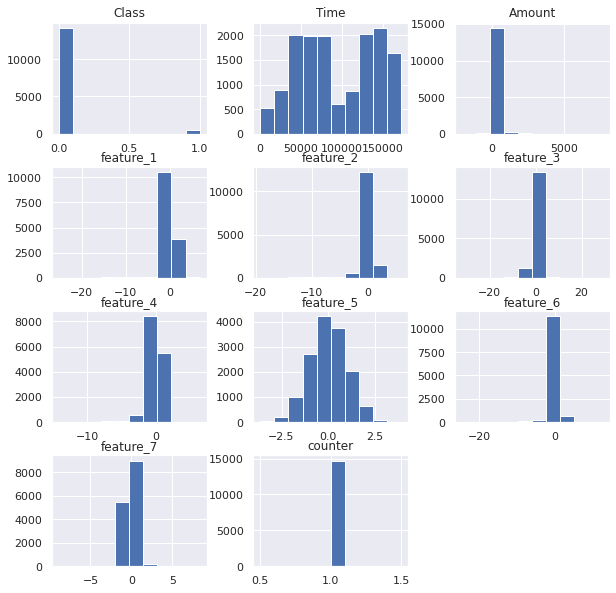

In [ ]:
h1=df.hist(figsize =(10, 10))

## Correlation matrix

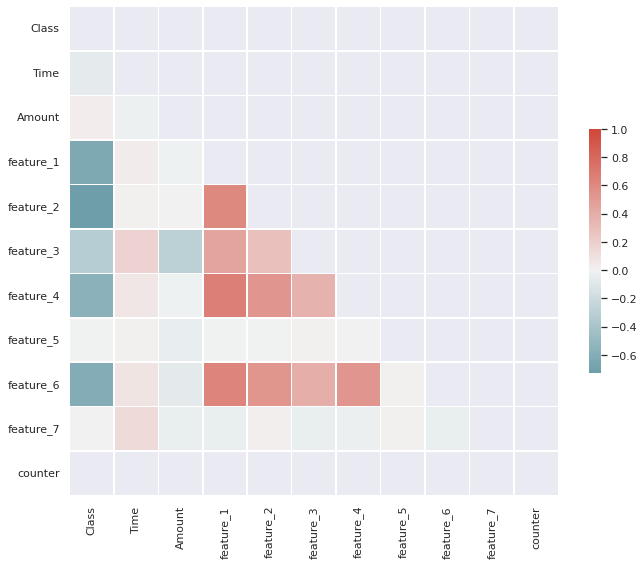

In [ ]:
# Compute the correlation matrix
corr = df.corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(215, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
Class,1.00,-0.06,0.03,-0.63,-0.73,-0.32,-0.57,-0.01,-0.60,0.00,NaN
Time,-0.06,1.00,-0.02,0.04,0.01,0.18,0.07,0.01,0.08,0.14,NaN
Amount,0.03,-0.02,1.00,-0.01,0.00,-0.29,-0.01,-0.05,-0.06,-0.03,NaN
feature_1,-0.63,0.04,-0.01,1.00,0.61,0.45,0.67,-0.00,0.64,-0.04,NaN
feature_2,-0.73,0.01,0.00,0.61,1.00,0.30,0.54,-0.00,0.55,0.03,NaN
feature_3,-0.32,0.18,-0.29,0.45,0.30,1.00,0.36,0.02,0.40,-0.03,NaN
feature_4,-0.57,0.07,-0.01,0.67,0.54,0.36,1.00,0.00,0.54,-0.02,NaN
feature_5,-0.01,0.01,-0.05,-0.00,-0.00,0.02,0.00,1.00,0.02,0.01,NaN
feature_6,-0.60,0.08,-0.06,0.64,0.55,0.40,0.54,0.02,1.00,-0.04,NaN
feature_7,0.00,0.14,-0.03,-0.04,0.03,-0.03,-0.02,0.01,-0.04,1.00,NaN


In [ ]:
Corr1 = df.corr(method='pearson')
print (Corr1)

           Class  Time  Amount  feature_1  feature_2  feature_3  feature_4  \
Class       1.00 -0.06    0.03      -0.63      -0.73      -0.32      -0.57   
Time       -0.06  1.00   -0.02       0.04       0.01       0.18       0.07   
Amount      0.03 -0.02    1.00      -0.01       0.00      -0.29      -0.01   
feature_1  -0.63  0.04   -0.01       1.00       0.61       0.45       0.67   
feature_2  -0.73  0.01    0.00       0.61       1.00       0.30       0.54   
feature_3  -0.32  0.18   -0.29       0.45       0.30       1.00       0.36   
feature_4  -0.57  0.07   -0.01       0.67       0.54       0.36       1.00   
feature_5  -0.01  0.01   -0.05      -0.00      -0.00       0.02       0.00   
feature_6  -0.60  0.08   -0.06       0.64       0.55       0.40       0.54   
feature_7   0.00  0.14   -0.03      -0.04       0.03      -0.03      -0.02   
counter      NaN   NaN     NaN        NaN        NaN        NaN        NaN   

           feature_5  feature_6  feature_7  counter  
Class    

In [ ]:
Corr1 = Corr1.stack().reset_index()
print (Corr1)

      level_0    level_1     0
0       Class      Class  1.00
1       Class       Time -0.06
2       Class     Amount  0.03
3       Class  feature_1 -0.63
4       Class  feature_2 -0.73
..        ...        ...   ...
95  feature_7  feature_3 -0.03
96  feature_7  feature_4 -0.02
97  feature_7  feature_5  0.01
98  feature_7  feature_6 -0.04
99  feature_7  feature_7  1.00

[100 rows x 3 columns]


In [ ]:
filter_list = ['Class']
TheList = Corr1[Corr1.level_1.isin(filter_list)]
TheList

,level_0,level_1,0
0,Class,Class,1.00
10,Time,Class,-0.06
20,Amount,Class,0.03
30,feature_1,Class,-0.63
40,feature_2,Class,-0.73
50,feature_3,Class,-0.32
60,feature_4,Class,-0.57
70,feature_5,Class,-0.01
80,feature_6,Class,-0.60
90,feature_7,Class,0.00


|index|level\_0|level\_1|0|
|---|---|---|---|
|40|feature\_2|Class|-0\.731601904367584|
|30|feature\_1|Class|-0\.63305053747431|
|80|feature\_6|Class|-0\.6003202475196212|
|60|feature\_4|Class|-0\.5650145206310672|
|50|feature\_3|Class|-0\.3243570652494519|
|10|Time|Class|-0\.055334162626851105|
|70|feature\_5|Class|-0\.005605754744117603|
|90|feature\_7|Class|0\.0019417904389500604|
|20|Amount|Class|0\.02941362705030742|
|0|Class|Class|1\.0|

## Kernell

Very cool KDE explanation: https://mathisonian.github.io/kde/

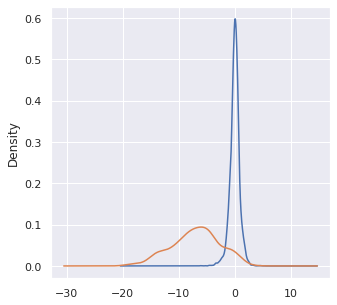

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_2.plot(kind='kde')

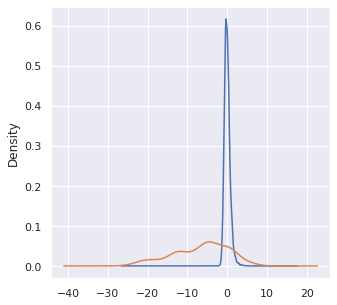

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_1.plot(kind='kde')

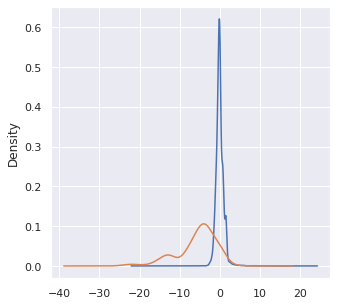

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_6.plot(kind='kde')

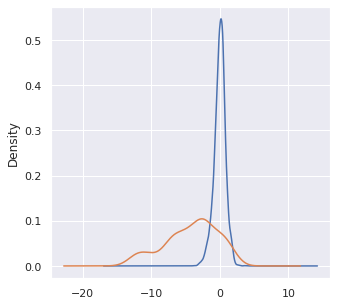

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_4.plot(kind='kde')

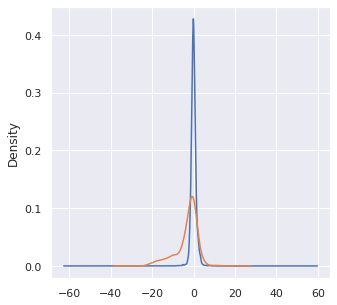

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_3.plot(kind='kde')

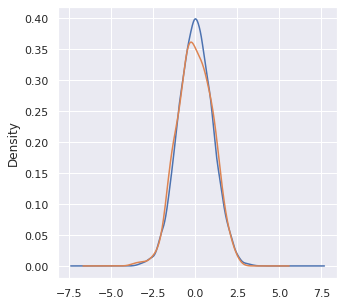

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_5.plot(kind='kde')

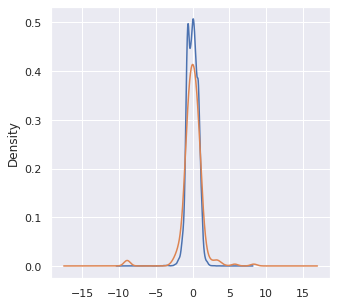

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").feature_7.plot(kind='kde')

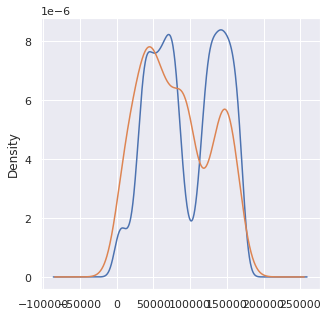

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").Time.plot(kind='kde')

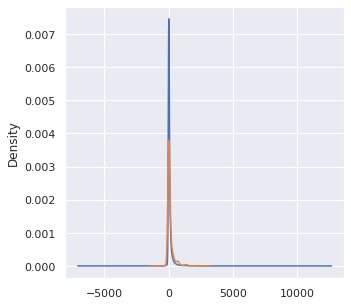

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df.groupby("Class").Amount.plot(kind='kde')

## Null values

In [ ]:
df.isnull().any()
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Class        False
Time         False
Amount       False
feature_1    False
feature_2    False
feature_3    False
feature_4    False
feature_5    False
feature_6     True
feature_7    False
counter      False
dtype: bool

feature_6    2331
dtype: int64

In [ ]:
df_adj=df.copy()

In [ ]:
df_adj.loc[df_adj.isnull().any(axis = 1), :]

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,NaN,-0.838932,1
10,0,132400,20.30,0.203640,0.079081,0.153710,-2.008118,1.275553,NaN,-0.098898,1
13,0,48370,-1.00,1.317149,-0.861068,0.265337,-0.004235,2.441940,NaN,0.358523,1
15,0,53620,83.08,-0.448016,0.464329,-0.535995,0.244026,1.025986,NaN,-0.284073,1
19,0,153652,-100.00,-0.116148,0.737735,-1.024870,0.522635,2.636732,NaN,-0.768389,1
...,...,...,...,...,...,...,...,...,...,...,...
14681,1,155965,0.77,-1.558545,-12.156587,-0.167445,-2.110863,1.290255,NaN,-0.556913,1
14684,1,157207,4.97,-1.481283,-8.229952,0.997798,-0.408471,1.006569,NaN,-0.713201,1
14698,1,165981,0.00,0.327464,0.984344,9.880564,-0.674357,1.087943,NaN,-0.130436,1
14701,1,166883,19.95,1.194212,-1.824839,-0.620324,1.842347,1.226075,NaN,0.831939,1


In [ ]:
df_adj.feature_6.describe()

count    12377.000000
mean        -0.176848
std          1.676405
min        -24.588262
25%         -0.570307
50%         -0.111279
75%          0.438038
max         12.701539
Name: feature_6, dtype: float64

In [ ]:
feature_6=df[['Class', 'feature_6']]
feature_6.head()

,Class,feature_6
0,0,-0.471390
1,0,NaN
2,0,-4.171672
3,0,0.252497
4,0,-0.455964


In [ ]:
import numpy as np
feature_6['Null_indicator']=np.select([feature_6.feature_6.isnull()],[1],0)
print(feature_6)

       Class  feature_6  Null_indicator
0          0  -0.471390               0
1          0        NaN               1
2          0  -4.171672               0
3          0   0.252497               0
4          0  -0.455964               0
...      ...        ...             ...
14703      1  -5.587794               0
14704      1  -3.232153               0
14705      1  -3.463891               0
14706      1        NaN               1
14707      1  -0.888722               0

[14708 rows x 3 columns]


In [ ]:
feature_6.describe()

,Class,feature_6,Null_indicator
count,14708.000000,12377.000000,14708.000000
mean,0.033451,-0.176848,0.158485
std,0.179818,1.676405,0.365208
min,0.000000,-24.588262,0.000000
25%,0.000000,-0.570307,0.000000
50%,0.000000,-0.111279,0.000000
75%,0.000000,0.438038,0.000000
max,1.000000,12.701539,1.000000


0    0.841515
1    0.158485
Name: Null_indicator, dtype: float64

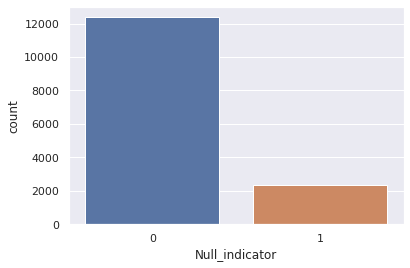

In [ ]:
r=sns.countplot(x=feature_6['Null_indicator'])
t=feature_6['Null_indicator'].value_counts() / len(feature_6['Null_indicator'])
t

In [ ]:
pd.crosstab(feature_6['Class'], feature_6['Null_indicator'])

Null_indicator,0,1
Class,,
0,11969,2247
1,408,84


In [ ]:
y=2247+84
y

2331

In [ ]:
z=2247/2331
z

0.963963963963964

In [ ]:
x=2331/14708
x

0.15848517813434865

In [ ]:
pivot = pd.pivot_table(
    data=feature_6,
    index='Class',
    aggfunc=['mean', 'sum', 'count']
)
print(pivot)

                mean                      sum                       count  \
      Null_indicator feature_6 Null_indicator    feature_6 Null_indicator   
Class                                                                       
0           0.158061  0.008952           2247   107.147457          14216   
1           0.170732 -5.627433             84 -2295.992690            492   

                 
      feature_6  
Class            
0         11969  
1           408  


In [ ]:
# Fill out the null values with zeros.
df_adj.feature_6.fillna(value = 0, inplace=True)
df_adj.loc[df_adj.isnull().any(axis = 1), :]

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter


In [ ]:
df.describe()
df_adj.describe()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,12377.000000,14708.000000,14708.0
mean,0.033451,94829.091311,83.662885,-0.210981,-0.228162,-0.099143,-0.132897,-0.000054,-0.176848,0.006219,1.0
std,0.179818,47346.554184,235.420993,1.896954,1.714838,1.750578,1.319391,1.002938,1.676405,0.750209,0.0
min,0.000000,12.000000,-2130.630000,-25.162799,-19.214325,-32.092129,-14.129855,-3.637604,-24.588262,-8.887017,1.0
25%,0.000000,54233.000000,4.490000,-0.510007,-0.485524,-0.713335,-0.523041,-0.680155,-0.570307,-0.538767,1.0
50%,0.000000,85805.500000,20.000000,-0.088723,0.018312,-0.079560,0.043841,-0.000925,-0.111279,0.006112,1.0
75%,0.000000,139157.500000,76.670000,0.387028,0.471558,0.598372,0.514149,0.680495,0.438038,0.530974,1.0
max,1.000000,172768.000000,7712.430000,6.739384,5.947222,29.162172,6.442798,3.903269,12.701539,8.361985,1.0


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
count,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.0
mean,0.033451,94829.091311,83.662885,-0.210981,-0.228162,-0.099143,-0.132897,-0.000054,-0.148820,0.006219,1.0
std,0.179818,47346.554184,235.420993,1.896954,1.714838,1.750578,1.319391,1.002938,1.539181,0.750209,0.0
min,0.000000,12.000000,-2130.630000,-25.162799,-19.214325,-32.092129,-14.129855,-3.637604,-24.588262,-8.887017,1.0
25%,0.000000,54233.000000,4.490000,-0.510007,-0.485524,-0.713335,-0.523041,-0.680155,-0.461314,-0.538767,1.0
50%,0.000000,85805.500000,20.000000,-0.088723,0.018312,-0.079560,0.043841,-0.000925,0.000000,0.006112,1.0
75%,0.000000,139157.500000,76.670000,0.387028,0.471558,0.598372,0.514149,0.680495,0.255377,0.530974,1.0
max,1.000000,172768.000000,7712.430000,6.739384,5.947222,29.162172,6.442798,3.903269,12.701539,8.361985,1.0


In [ ]:
df_adj.isnull().any()
null_columns = df_adj.columns[df_adj.isnull().any()]
df_adj[null_columns].isnull().sum()

Class        False
Time         False
Amount       False
feature_1    False
feature_2    False
feature_3    False
feature_4    False
feature_5    False
feature_6    False
feature_7    False
counter      False
dtype: bool

Series([], dtype: float64)

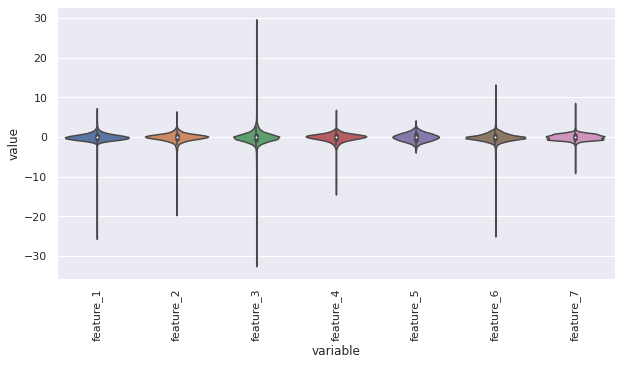

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(df.iloc[:, np.r_[3:10]]), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

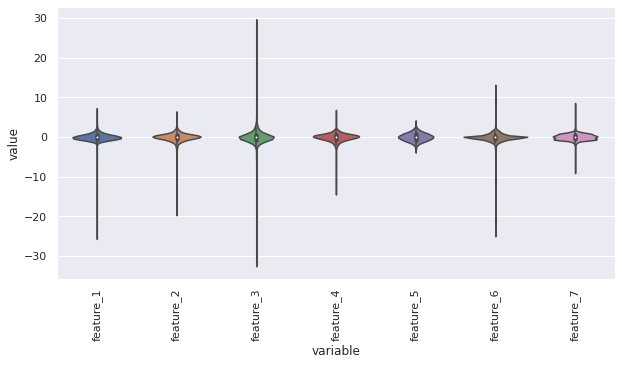

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
a = sns.violinplot(x='variable', y='value', data=pd.melt(df_adj.iloc[:, np.r_[3:10]]), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

## Histogram post Null adjustment

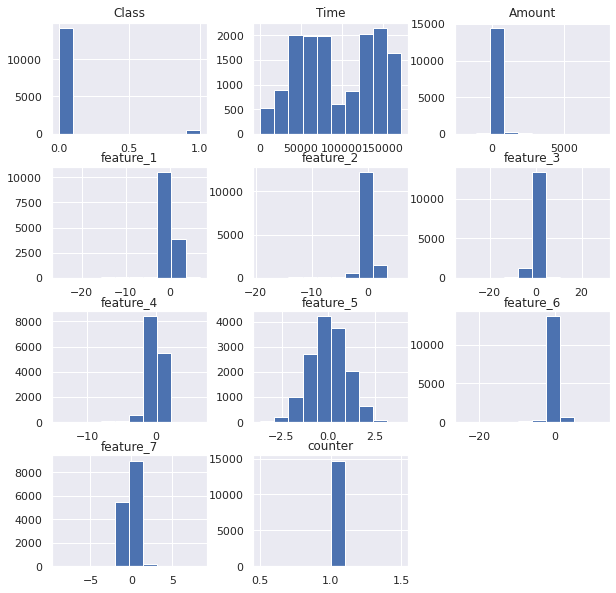

In [ ]:
h1=df_adj.hist(figsize =(10, 10))

## Correlation matrix post Null adjustment

In [ ]:
df_adj['counter'] = 1
df_adj.head()
TransbyClass = pd.concat([df_adj.groupby("Class")["counter"].sum(),df_adj.groupby("Class")["Amount"].sum(),df_adj.groupby("Class")["Amount"].mean()],axis=1)
TransbyClass.columns = ["Frequency", "SumAmount","MeanAmount"]
TransbyClass

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
0,0,162183,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.471390,0.741141,1
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,0.000000,-0.838932,1
2,0,26484,1937.66,1.457844,-0.899347,-6.059393,-1.784000,0.484257,-4.171672,1.195815,1
3,0,65751,320.05,-0.401365,-0.282106,-0.583587,1.345463,-1.038179,0.252497,-0.761357,1
4,0,137025,11.50,0.481656,-1.568433,3.699527,-0.296621,0.679977,-0.455964,0.534602,1


,Frequency,SumAmount,MeanAmount
Class,,,
0,14216,1171038.96,82.374716
1,492,59474.75,120.883638


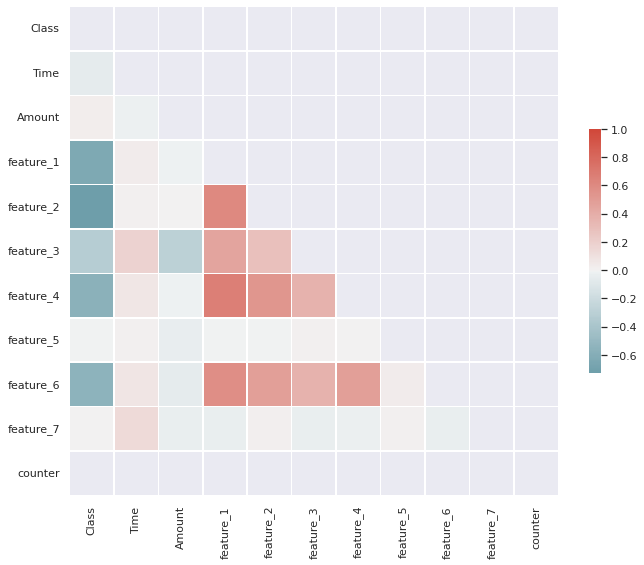

In [ ]:
# Compute the correlation matrix
corr = df_adj.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(215, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
Class,1.000000,-0.055334,0.029414,-0.633051,-0.731602,-0.324357,-0.565015,-0.005606,-0.546071,0.001942,NaN
Time,-0.055334,1.000000,-0.018157,0.038543,0.006201,0.183121,0.071084,0.010750,0.075318,0.139662,NaN
Amount,0.029414,-0.018157,1.000000,-0.009628,0.004166,-0.288870,-0.012826,-0.046823,-0.059667,-0.030074,NaN
feature_1,-0.633051,0.038543,-0.009628,1.000000,0.607861,0.453544,0.666536,-0.001289,0.581978,-0.037936,NaN
feature_2,-0.731602,0.006201,0.004166,0.607861,1.000000,0.295029,0.538754,-0.003682,0.490909,0.025275,NaN
feature_3,-0.324357,0.183121,-0.288870,0.453544,0.295029,1.000000,0.364413,0.016634,0.366949,-0.032970,NaN
feature_4,-0.565015,0.071084,-0.012826,0.666536,0.538754,0.364413,1.000000,0.004971,0.491104,-0.022879,NaN
feature_5,-0.005606,0.010750,-0.046823,-0.001289,-0.003682,0.016634,0.004971,1.000000,0.039090,0.008775,NaN
feature_6,-0.546071,0.075318,-0.059667,0.581978,0.490909,0.366949,0.491104,0.039090,1.000000,-0.036509,NaN
feature_7,0.001942,0.139662,-0.030074,-0.037936,0.025275,-0.032970,-0.022879,0.008775,-0.036509,1.000000,NaN


In [ ]:
Corr2 = df_adj.corr(method='pearson')
print (Corr2)

              Class      Time    Amount  feature_1  feature_2  feature_3  \
Class      1.000000 -0.055334  0.029414  -0.633051  -0.731602  -0.324357   
Time      -0.055334  1.000000 -0.018157   0.038543   0.006201   0.183121   
Amount     0.029414 -0.018157  1.000000  -0.009628   0.004166  -0.288870   
feature_1 -0.633051  0.038543 -0.009628   1.000000   0.607861   0.453544   
feature_2 -0.731602  0.006201  0.004166   0.607861   1.000000   0.295029   
feature_3 -0.324357  0.183121 -0.288870   0.453544   0.295029   1.000000   
feature_4 -0.565015  0.071084 -0.012826   0.666536   0.538754   0.364413   
feature_5 -0.005606  0.010750 -0.046823  -0.001289  -0.003682   0.016634   
feature_6 -0.546071  0.075318 -0.059667   0.581978   0.490909   0.366949   
feature_7  0.001942  0.139662 -0.030074  -0.037936   0.025275  -0.032970   
counter         NaN       NaN       NaN        NaN        NaN        NaN   

           feature_4  feature_5  feature_6  feature_7  counter  
Class      -0.565015  

In [ ]:
Corr2 = Corr2.stack().reset_index()
print (Corr2)

      level_0    level_1         0
0       Class      Class  1.000000
1       Class       Time -0.055334
2       Class     Amount  0.029414
3       Class  feature_1 -0.633051
4       Class  feature_2 -0.731602
..        ...        ...       ...
95  feature_7  feature_3 -0.032970
96  feature_7  feature_4 -0.022879
97  feature_7  feature_5  0.008775
98  feature_7  feature_6 -0.036509
99  feature_7  feature_7  1.000000

[100 rows x 3 columns]


In [ ]:
filter_list = ['Class']
TheList = Corr2[Corr2.level_1.isin(filter_list)]
TheList

,level_0,level_1,0
0,Class,Class,1.000000
10,Time,Class,-0.055334
20,Amount,Class,0.029414
30,feature_1,Class,-0.633051
40,feature_2,Class,-0.731602
50,feature_3,Class,-0.324357
60,feature_4,Class,-0.565015
70,feature_5,Class,-0.005606
80,feature_6,Class,-0.546071
90,feature_7,Class,0.001942


|index|level\_0|level\_1|0|
|---|---|---|---|
|40|feature\_2|Class|-0\.731601904367584|
|30|feature\_1|Class|-0\.63305053747431|
|60|feature\_4|Class|-0\.5650145206310672|
|80|feature\_6|Class|-0\.5460709057168188|
|50|feature\_3|Class|-0\.3243570652494519|
|10|Time|Class|-0\.055334162626851105|
|70|feature\_5|Class|-0\.005605754744117603|
|90|feature\_7|Class|0\.0019417904389500604|
|20|Amount|Class|0\.02941362705030742|
|0|Class|Class|1\.0|

## Kernell post Null adjustment

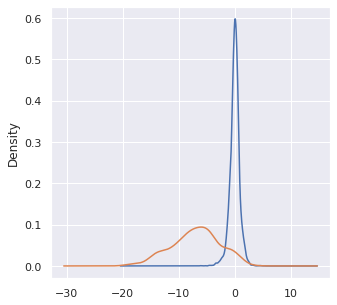

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_2.plot(kind='kde')

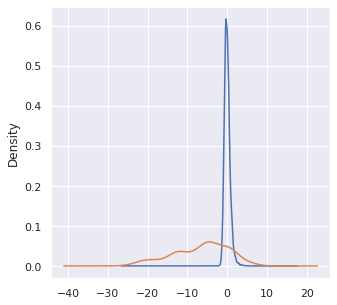

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_1.plot(kind='kde')

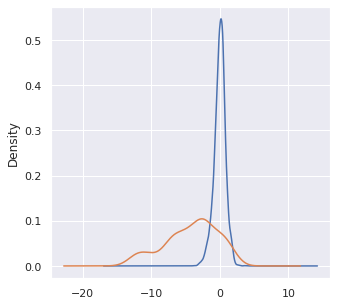

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_4.plot(kind='kde')

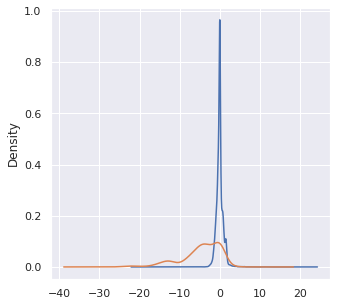

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_6.plot(kind='kde')

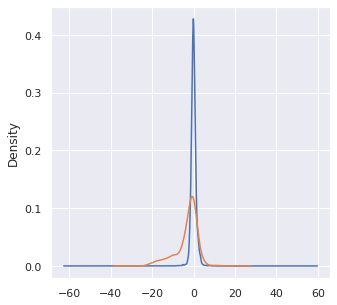

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_3.plot(kind='kde')

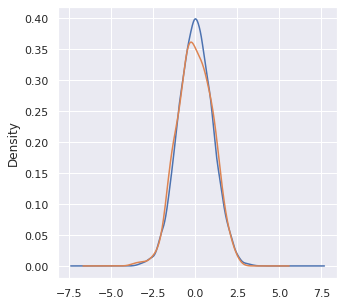

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_5.plot(kind='kde')

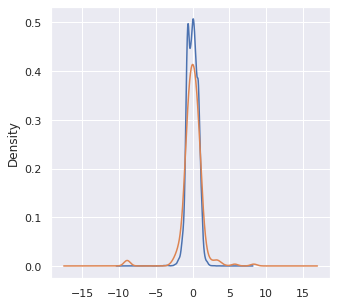

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").feature_7.plot(kind='kde')

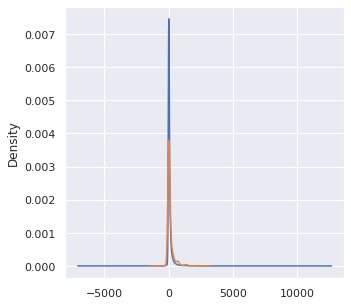

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").Amount.plot(kind='kde')

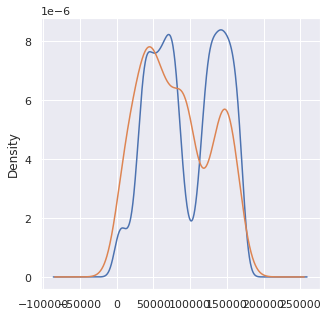

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
kde=df_adj.groupby("Class").Time.plot(kind='kde')

## Multicollinearity

VIF starts at 1 and has no upper limit.
VIF = 1, no correlation between the independent variable and the other variables.
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others.


Other [Sources](https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself) suggest that multicollinearity does not impact xgboost.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = df_adj[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

     feature       VIF
0  feature_1  2.527563
1  feature_2  1.758187
2  feature_3  1.296454
3  feature_4  1.957487
4  feature_5  1.002890
5  feature_6  1.657583
6  feature_7  1.006551


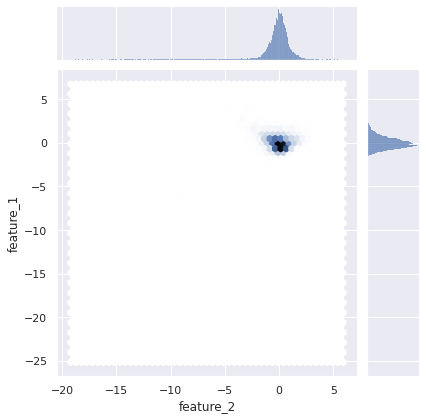

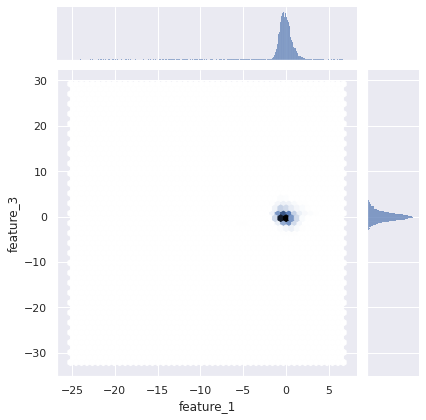

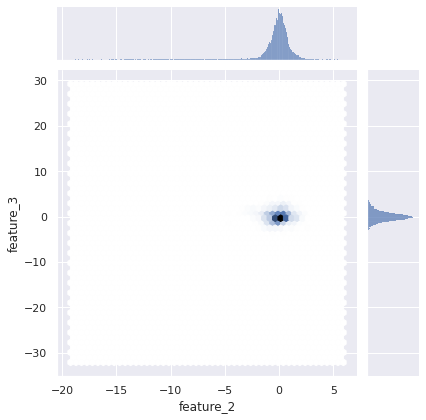

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(rc={'figure.figsize':(5,5)})
t1=sns.jointplot(data=df_adj, x="feature_2", y="feature_1", kind="hex")
plt.show()

sns.set(rc={'figure.figsize':(5,5)})
t1=sns.jointplot(data=df_adj, x="feature_1", y="feature_3", kind="hex")
plt.show()

sns.set(rc={'figure.figsize':(5,5)})
t2=sns.jointplot(data=df_adj, x="feature_2", y="feature_3", kind="hex")
plt.show()

In [ ]:
#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development
X = df[['Time', 'Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = df['Class']

## Candidate variables after Null Adjustment


|index|level\_0|level\_1|0|
|---|---|---|---|
|40|feature\_2|Class|-0\.731601904367584|
|30|feature\_1|Class|-0\.63305053747431|
|60|feature\_4|Class|-0\.5650145206310672|
|80|feature\_6|Class|-0\.5460709057168188|
|50|feature\_3|Class|-0\.3243570652494519|
|10|Time|Class|-0\.055334162626851105|
|70|feature\_5|Class|-0\.005605754744117603|
|90|feature\_7|Class|0\.0019417904389500604|
|20|Amount|Class|0\.02941362705030742|
|0|Class|Class|1\.0|

### MRM Assessment

MRM performed model development data assessment for completness, accuracy and correctness and noted following findings:


1. The distribution analysis did not reveal any issues, except for the feature_5 being most nornally distributed.
2. The correlation analysis on full data shows that there is negative relationship between Class and all independent variables except for the feature_7.
3. The top variables correlated are feature_2, 1, 6, and 4.
4. The kernell density plots confirm what correlation analysis showed.
5. The accuracy of correlation analysis was veryfied with the null values check.The feature_6 has 16% missing values and 96% of them belong to non-fraudulent transactions. Filling in missiung values with zeros for feature_6 did not impact much its distribution, but it impacted its function in the model as that feature is now less correlated to the Class variable (-60% vs -54%). Further busienss knowledge on the reasoning behind missing values and benefits of replacing nulls would be required.
6. The independent variables do not show issue of multicollinearity.
7. There is no proper variable selection process aligned with this modeling exercise. All available variables could be included and some type of stepwise selection could be innitiated. In addition, variable importance analysis (IV) could be used after model is already created to perform iterative process of variable inclusion and rejection. In addition, binning could be considered.

# Model Conceptual Soundness

In the standard Model Validation report, this section would contain detailed explanation on why xgboost is conceptually correct for fraud modeling.

# Model Technical Soundness

In the standard Model Validation report, this section would contain detailed explanation if xgboost is designed technically correct for fraud modeling on given data according to the work plan established before hand with management and following model vaidation standards.

In [ ]:
#Original Code Lines
!pip install xgboost
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb
print(xgb.__version__)

0.90


####Original Code Lines

In [ ]:
#Original Code Lines
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
df=creditcard.copy()
print(df.shape)
df['counter'] = 1
df.head(2)

(14708, 10)


,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
0,0,162183,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.47139,0.741141,1
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,NaN,-0.838932,1


In [ ]:
#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development

X = df[['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y2 = df[['Class', 'counter']]

y = df['Class']

In [ ]:
X.describe()
y.describe()

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5
count,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000,14708.000000
mean,83.662885,-0.210981,-0.228162,-0.099143,-0.132897,-0.000054
std,235.420993,1.896954,1.714838,1.750578,1.319391,1.002938
min,-2130.630000,-25.162799,-19.214325,-32.092129,-14.129855,-3.637604
25%,4.490000,-0.510007,-0.485524,-0.713335,-0.523041,-0.680155
50%,20.000000,-0.088723,0.018312,-0.079560,0.043841,-0.000925
75%,76.670000,0.387028,0.471558,0.598372,0.514149,0.680495
max,7712.430000,6.739384,5.947222,29.162172,6.442798,3.903269


count    14708.000000
mean         0.033451
std          0.179818
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Class, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.20, random_state=0)

In [ ]:
X_train.head(2)
y_train.head(2)

pd.crosstab(y_train['counter'], y_train['Class'])

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5
10155,1.00,-0.365197,0.424499,-0.717125,0.457802,-0.290716
5875,17.99,-0.060953,-0.472963,-0.300478,0.437726,-0.191244


,Class,counter
10155,0,1
5875,0,1


Class,0,1
counter,,
1,11368,398


In [ ]:
X_test.head(2)
y_test.head(2)
pd.crosstab(y_test['counter'], y_test['Class'])

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5
3471,10.99,-0.208491,0.434408,0.194591,-0.007959,1.633414
4411,32.08,-0.420296,0.605013,0.036392,0.325173,0.158411


,Class,counter
3471,0,1
4411,0,1


Class,0,1
counter,,
1,2848,94


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (11766, 6)
y_train shape: (11766, 2)
X_test shape: (2942, 6)
y_test shape: (2942, 2)


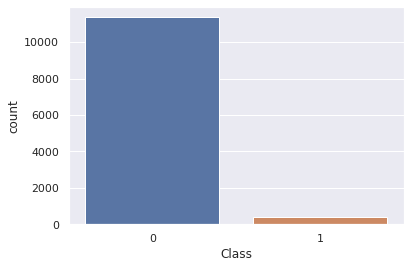

In [ ]:
sns.countplot(y_train['Class'])

In [ ]:
y_train.value_counts() / len(y_train)
y_test.value_counts()

Class  counter
0      1          0.966174
1      1          0.033826
dtype: float64

Class  counter
0      1          2848
1      1            94
dtype: int64

|index|level\_0|level\_1|0|
|---|---|---|---|
|40|feature\_2|Class|-0\.731601904367584|
|30|feature\_1|Class|-0\.63305053747431|
|80|feature\_6|Class|-0\.6003202475196212|
|60|feature\_4|Class|-0\.5650145206310672|
|50|feature\_3|Class|-0\.3243570652494519|
|10|Time|Class|-0\.055334162626851105|
|70|feature\_5|Class|-0\.005605754744117603|
|90|feature\_7|Class|0\.0019417904389500604|
|20|Amount|Class|0\.02941362705030742|
|0|Class|Class|1\.0|

In [ ]:
#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development
X = df[['feature_2', 'feature_1', 'feature_6', 'feature_4']]

#X = df[['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y2 = df[['Class', 'counter']]

y = df['Class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [ ]:
#Original Code Lines


# Hyperparameter Tuning
cv_params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 500, 1000]}    # candidate parameter
fix_params = {'objective': 'binary:logistic', 'eval_metric':'logloss'}   # other parameters
cv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring='roc_auc', cv=3)
cv.fit(X_train, y_train)
cv.best_params_

GridSearchCV(cv=3, estimator=XGBClassifier(eval_metric='logloss'),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc')

{'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
print(cv.best_params_)

{'learning_rate': 0.1, 'n_estimators': 1000}


In [ ]:
#Original Code Lines

best_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'objective':'binary:logistic', 'eval_metric':'logloss'}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', n_estimators=1000)

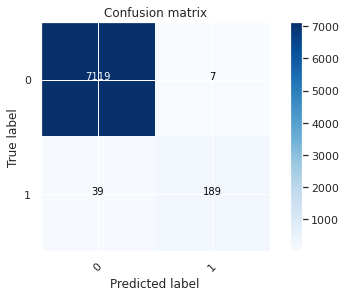

Precision =     0.964
Recall (TPR) =  0.829
Fallout (FPR) = 9.823e-04


In [ ]:
#Original Code Lines


# Predict Model and set threshold to 0.5
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [ ]:
roc_auc_score(y_test, y_pred)

0.9139825250749665

In [ ]:
print(cm)

[[7119    7]
 [  39  189]]


In [ ]:
y_pred = model.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 0


### MRM Assessment

MRM performed model technical soundness assessment for completness, accuracy and correctness and noted following observations:



*   The best paramenters were hard coded differently than what model grid search established

** from grid: {'learning_rate': 0.01, 'n_estimators': 1000}

</p>

** hard coded:{learning_rate':0.1, 'n_estimators':500}


*   Model performs well, but it is going to be evalueated for overfitting,



In [ ]:
print(cm)

[[7119    7]
 [  39  189]]


In [ ]:
cv.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
cv.best_estimator_

XGBClassifier(eval_metric='logloss', n_estimators=1000)

In [ ]:
y_pred = model.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 0


In [ ]:
from sklearn.metrics import explained_variance_score
y_pred = model.predict(X_test)
print(explained_variance_score(y_pred,y_test))

0.7596096275895103


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(accuracy_score(y_pred,y_test, normalize=True))

0.9937449007342942


In [ ]:
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_pred,y_test))

0.9794186324991019


In [ ]:
from sklearn.metrics import average_precision_score
y_pred = model.predict(X_test)
print(average_precision_score(y_pred,y_test))

0.8002939681948958


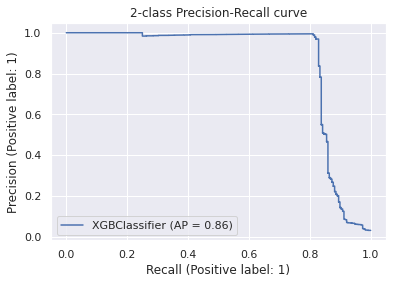

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="XGBClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

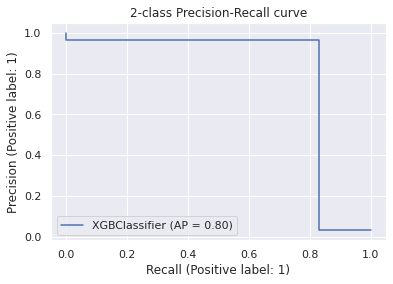

In [ ]:
y_pred = model.predict(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="XGBClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
print(f1_score(y_pred,y_test, average='weighted'))

0.9939739356640552


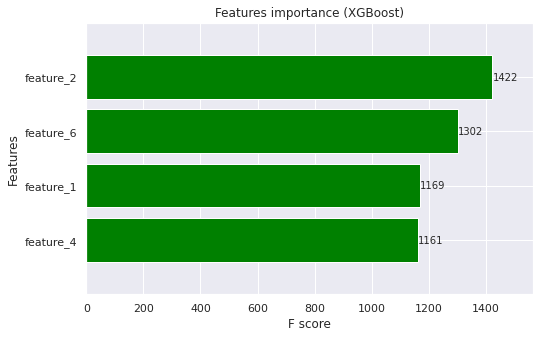

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

## MRM Challenger Models

Considereation that could be communicated to model owner, and discussed with businedd owners and SME regarding variable logic:

1. MRM would like to propose to consider adjusting the 16% of missing values of feature_6 with either zeros or mean, and  introduce it in the model.
2. MRM would like to not discard feature_7 and try to evaluate model with it if it is meaningful to the business logic,
3. MRM would suggest that model owner establishes standarized process of variable selection which can be replicated by modelers and validators in the future,
4. MRM would like to look into creating WoE on binned variables and evaluating IV if it improved results,
5. MRM suggests excluding the variable Amount as independent variable, as it can be a counfounding variable to target variable "Class",
6. MRM thinks that the variable Amount can only be a positive and non-zero value (fraudulent transaction needs to carry monetary risk with it and must be meaningful to the business), therefore, the underlying logic of the collected variable "Amount" must be evaluted and possibly, re-run the current model on adjusted data.

In [ ]:
# Full data set with all variables and misisng values for feature_6
df=creditcard.copy()
print(df.shape)
print(df.head(3))

(14708, 10)
   Class    Time   Amount  feature_1  feature_2  feature_3  feature_4  \
0      0  162183     2.99   0.469860  -0.664254   0.160589   0.157691   
1      0  120967     1.98  -0.623472   0.081326   0.543172   0.109356   
2      0   26484  1937.66   1.457844  -0.899347  -6.059393  -1.784000   

   feature_5  feature_6  feature_7  
0   0.818296  -0.471390   0.741141  
1   1.248131        NaN  -0.838932  
2   0.484257  -4.171672   1.195815  


In [ ]:
# Adjusted data set with all variables and misisng values for feature_6 replaced with zeros,
print(df_adj.shape)
print(df_adj.head(3))

(14708, 11)
   Class    Time   Amount  feature_1  feature_2  feature_3  feature_4  \
0      0  162183     2.99   0.469860  -0.664254   0.160589   0.157691   
1      0  120967     1.98  -0.623472   0.081326   0.543172   0.109356   
2      0   26484  1937.66   1.457844  -0.899347  -6.059393  -1.784000   

   feature_5  feature_6  feature_7  counter  
0   0.818296  -0.471390   0.741141        1  
1   1.248131   0.000000  -0.838932        1  
2   0.484257  -4.171672   1.195815        1  


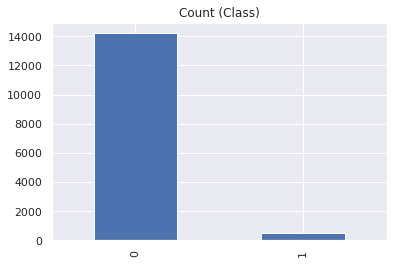

In [ ]:
df_adj['Class'].value_counts().plot(kind='bar', title='Count (Class)');

#### Modeling Fraud on Amount>0 only

In [ ]:
#Original Code Lines
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
positive_only_df = creditcard[creditcard['Amount'] > 0]
positive_only_df.describe()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
count,14251.000000,14251.000000,14251.000000,14251.000000,14251.000000,14251.000000,14251.000000,14251.000000,12294.000000,14251.000000
mean,0.032068,94725.173181,88.488442,-0.203445,-0.217450,-0.100693,-0.130680,-0.059061,-0.172319,0.003556
std,0.176187,47367.719274,235.338348,1.874967,1.672912,1.747678,1.310453,0.942791,1.665923,0.747901
min,0.000000,12.000000,0.010000,-25.162799,-19.214325,-32.092129,-14.129855,-3.637604,-24.588262,-8.887017
25%,0.000000,54114.500000,5.550000,-0.509619,-0.482914,-0.713112,-0.523059,-0.699244,-0.570109,-0.539868
50%,0.000000,85428.000000,22.080000,-0.086266,0.017590,-0.080767,0.043641,-0.030846,-0.112224,0.003768
75%,0.000000,139111.000000,80.000000,0.386710,0.468652,0.594838,0.513558,0.619968,0.437678,0.529248
max,1.000000,172768.000000,7712.430000,6.739384,5.947222,29.162172,6.442798,1.999610,12.701539,8.316275


In [ ]:
#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development
X = positive_only_df[['feature_2', 'feature_1', 'feature_6', 'feature_4']]

#X = positive_only_df[['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = positive_only_df['Class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

In [ ]:
#Original Code Lines


# Hyperparameter Tuning
cv_params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 500, 1000]}    # candidate parameter
fix_params = {'objective': 'binary:logistic', 'eval_metric':'logloss'}   # other parameters
cv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring='roc_auc', cv=3)
cv.fit(X_train, y_train)
cv.best_params_

GridSearchCV(cv=3, estimator=XGBClassifier(eval_metric='logloss'),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc')

{'learning_rate': 0.01, 'n_estimators': 500}

In [ ]:
print(cv.best_params_)

{'learning_rate': 0.01, 'n_estimators': 500}


In [ ]:
#Original Code Lines

best_params = {'learning_rate': 0.01, 'n_estimators': 500, 'objective':'binary:logistic', 'eval_metric':'logloss'}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)


XGBClassifier(eval_metric='logloss', learning_rate=0.01, n_estimators=500)

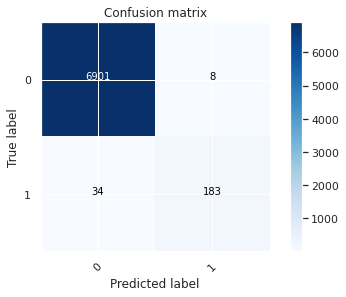

Precision =     0.958
Recall (TPR) =  0.843
Fallout (FPR) = 1.158e-03


In [ ]:
# Predict Model and set threshold to 0.5
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);


In [ ]:
roc_auc_score(y_test, y_pred)

0.9210800311888654

In [ ]:
print(cm)

[[6901    8]
 [  34  183]]


In [ ]:
y_pred = model.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 0


#### Oversampling:

In [ ]:
# Oversampling:

from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', n_jobs=-1)

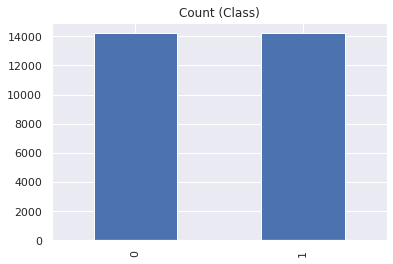

In [ ]:
target = 'Class'
labels = ['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7']

X_sm, y_sm = smote.fit_resample(df_adj[labels], df_adj['Class'])

df2 = pd.DataFrame(X_sm, columns=labels)
df2['Class'] = y_sm

df2['Class'].value_counts().plot(kind='bar', title='Count (Class)');

#### Original Model after oversampling (1)

In [ ]:
#Original Code Lines
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)


In [ ]:
print(df2.shape)


#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development
X = df2[['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = df2['Class']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")




(28432, 9)
X_train shape: (19902, 6)
y_train shape: (19902,)
X_test shape: (8530, 6)
y_test shape: (8530,)


0    0.502311
1    0.497689
Name: Class, dtype: float64

1    4311
0    4219
Name: Class, dtype: int64

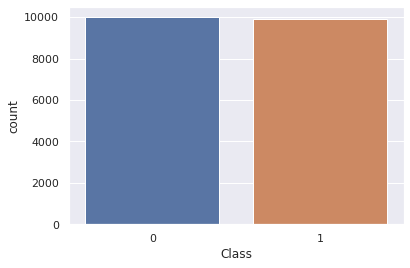

In [ ]:
sns.countplot(x=y_train)
y_train.value_counts() / len(y_train)
y_test.value_counts()

In [ ]:
#Original Code Lines


# Hyperparameter Tuning
cv_params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 500, 1000]}    # candidate parameter
fix_params = {'objective': 'binary:logistic', 'eval_metric':'logloss'}   # other parameters
cv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring='roc_auc', cv=3)
cv.fit(X_train, y_train)
cv.best_params_


print(cv.best_params_)

GridSearchCV(cv=3, estimator=XGBClassifier(eval_metric='logloss'),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc')

{'learning_rate': 0.1, 'n_estimators': 1000}

{'learning_rate': 0.1, 'n_estimators': 1000}


In [ ]:
#Original Code Lines

best_params = {'learning_rate':0.1, 'n_estimators':500, 'objective':'binary:logistic', 'eval_metric':'logloss'}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', n_estimators=500)

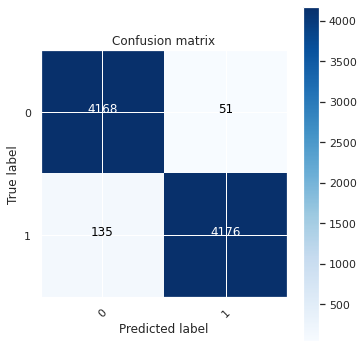

Precision =     0.988
Recall (TPR) =  0.969
Fallout (FPR) = 1.209e-02


In [ ]:
#Original Code Lines


# Predict Model and set threshold to 0.5
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [ ]:
roc_auc_score(y_test, y_pred)

0.9827030946427692

In [ ]:
y_pred = model.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 1


#### Original Model after oversampling (2)

In [ ]:
#Original Code Lines
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
print(df2.shape)


(28432, 9)


In [ ]:
#Original Code Lines


# Train Test split
# 'feature_6' has missing value and 'feature_7' are not useful in previous analysis.
# Therefore they are excluded from the model development
X = df2[['Amount', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = df2['Class']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (19902, 6)
y_train shape: (19902,)
X_test shape: (8530, 6)
y_test shape: (8530,)


0   0.50
1   0.50
Name: Class, dtype: float64

1    4311
0    4219
Name: Class, dtype: int64

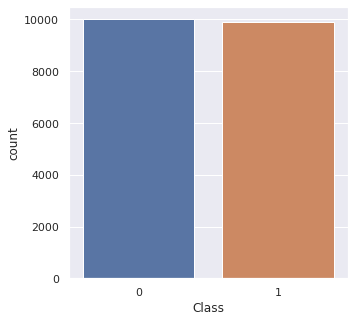

In [ ]:
sns.countplot(x=y_train)
y_train.value_counts() / len(y_train)
y_test.value_counts()


In [ ]:
#Original Code Lines


# Hyperparameter Tuning
cv_params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 500, 1000]}    # candidate parameter
fix_params = {'objective': 'binary:logistic', 'eval_metric':'logloss'}   # other parameters
cv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring='roc_auc', cv=3)
cv.fit(X_train, y_train)
cv.best_params_

GridSearchCV(cv=3, estimator=XGBClassifier(eval_metric='logloss'),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 500, 1000]},
             scoring='roc_auc')

{'learning_rate': 0.1, 'n_estimators': 1000}

{'learning_rate': 0.1, 'n_estimators': 1000}


In [ ]:
print(cv.best_params_)

{'learning_rate': 0.1, 'n_estimators': 1000}


In [ ]:
#Original Code Lines

best_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'objective':'binary:logistic', 'eval_metric':'logloss'}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', n_estimators=1000)

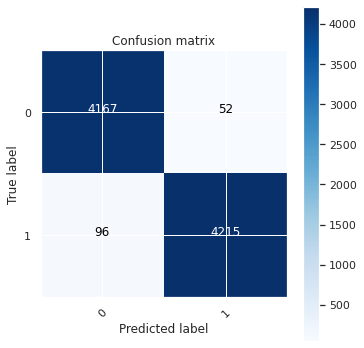

Precision =     0.988
Recall (TPR) =  0.978
Fallout (FPR) = 1.233e-02


In [ ]:
#Original Code Lines


# Predict Model and set threshold to 0.5
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [ ]:
roc_auc_score(y_test, y_pred, average=None)

0.9827030946427692

In [ ]:
y_pred = model.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 1


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.30 # simple validation using train_test_split
TEST_SIZE = 0.30 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 20181000

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.09
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [ ]:
df_adj.head()

,Class,Time,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
0,0,162183,2.99,0.469860,-0.664254,0.160589,0.157691,0.818296,-0.471390,0.741141,1
1,0,120967,1.98,-0.623472,0.081326,0.543172,0.109356,1.248131,0.000000,-0.838932,1
2,0,26484,1937.66,1.457844,-0.899347,-6.059393,-1.784000,0.484257,-4.171672,1.195815,1
3,0,65751,320.05,-0.401365,-0.282106,-0.583587,1.345463,-1.038179,0.252497,-0.761357,1
4,0,137025,11.50,0.481656,-1.568433,3.699527,-0.296621,0.679977,-0.455964,0.534602,1


,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,Class
count,"28,432.00","28,432.00","28,432.00","28,432.00","28,432.00","28,432.00","28,432.00","28,432.00","28,432.00"
mean,101.30,-3.22,-3.45,-1.55,-2.00,-0.02,-2.34,-0.01,0.50
std,245.12,5.73,4.53,4.11,3.33,0.93,4.16,1.11,0.50
min,"-2,130.63",-25.16,-19.21,-32.09,-14.13,-3.64,-24.59,-8.89,0.00
25%,1.09,-5.35,-6.64,-1.75,-3.40,-0.64,-3.67,-0.51,0.00
50%,17.41,-0.55,-1.12,-0.45,-0.65,-0.04,-0.51,0.01,0.50
75%,99.99,0.22,0.09,0.46,0.29,0.59,0.00,0.53,1.00
max,"7,712.43",6.74,5.95,29.16,6.44,3.90,12.70,8.36,1.00


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
2002,1.01,0.53,0.99,-2.15,-0.94,0.03,0.74
6984,1.31,-0.73,1.06,0.06,0.88,-0.10,-0.99
13032,-0.31,0.20,0.25,-0.06,-1.08,0.04,0.69
5578,-0.81,-0.07,0.74,1.27,0.84,-0.99,-0.66
372,-0.45,0.31,-0.07,0.54,0.53,0.75,0.74
...,...,...,...,...,...,...,...
3691,0.08,0.61,-0.25,-0.41,0.26,-1.70,0.26
24378,-7.13,-6.58,0.41,-4.41,1.24,-0.04,1.23
22774,-8.65,-7.10,-3.08,-6.79,-1.13,-5.72,-0.03
27553,-4.07,-4.46,-0.56,-2.38,-0.53,-3.43,0.47


RandomForestClassifier(n_jobs=4, random_state=20181000, verbose=False)

<Figure size 504x288 with 0 Axes>

Text(0.5, 1.0, 'Features importance')

[Text(0, 0, 'feature_2'),
 Text(0, 0, 'feature_1'),
 Text(0, 0, 'feature_6'),
 Text(0, 0, 'feature_4'),
 Text(0, 0, 'feature_3'),
 Text(0, 0, 'feature_7'),
 Text(0, 0, 'feature_5')]

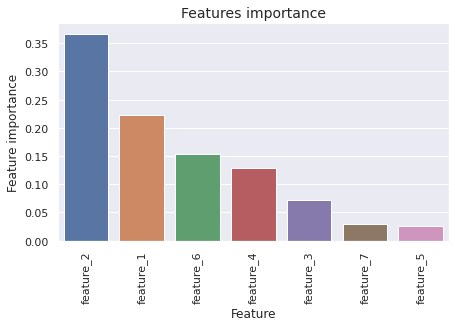

In [ ]:
df2.describe()


target = 'Class'
predictors_adj = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7']

train_df_adj, test_df_adj = train_test_split(df_adj, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df_adj, valid_df_adj = train_test_split(train_df_adj, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )


train_df_adj[predictors_adj]

clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

clf.fit(train_df_adj[predictors_adj], train_df_adj[target].values)

preds = clf.predict(valid_df_adj[predictors_adj])

tmp = pd.DataFrame({'Feature': predictors_adj, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

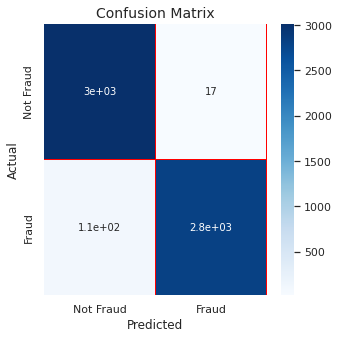

In [ ]:
cm = pd.crosstab(valid_df_adj[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Red", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df_adj[target].values, preds)

0.9791475699042507

In [ ]:
preds = clf.predict(valid_df_adj[predictors_adj])
print('Predicted Class: %d' % preds[1])

Predicted Class: 0


#### AdaBoost

An [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.10 # simple validation using train_test_split
TEST_SIZE = 0.10 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 20181000

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [ ]:
target = 'Class'
predictors = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_7']

In [ ]:
target = 'Class'
predictors = ['feature_6', 'feature_2']

train_df, test_df = train_test_split(df_adj, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

train_df[predictors]
train_df[target]

,feature_6,feature_2
5665,-0.610260,0.660932
7594,0.000000,-1.969372
9336,-0.092904,0.202364
8165,-1.722381,-2.672974
5406,1.067634,-0.756994
...,...,...
12957,-0.020386,0.230266
3989,0.126292,0.496136
3085,-0.787234,0.955187
2284,-0.433749,-0.108027


5665     0
7594     0
9336     0
8165     0
5406     0
        ..
12957    0
3989     0
3085     0
2284     0
10669    0
Name: Class, Length: 11913, dtype: int64

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=NUM_ESTIMATORS)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=20181000)

In [ ]:
preds = clf.predict(valid_df[predictors])

<Figure size 504x288 with 0 Axes>

Text(0.5, 1.0, 'Features importance')

[Text(0, 0, 'feature_2'), Text(0, 0, 'feature_6')]

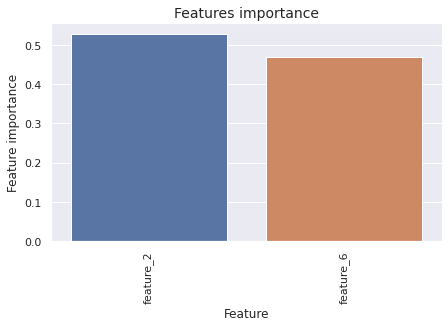

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

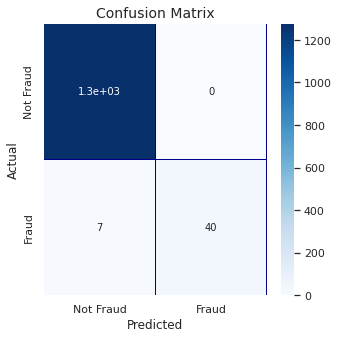

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.925531914893617

In [ ]:
print(cm)

Predicted     0   1
Actual             
0          1277   0
1             7  40


In [ ]:
preds = clf.predict(valid_df[predictors])
print('Predicted Class: %d' % preds[1])

Predicted Class: 0


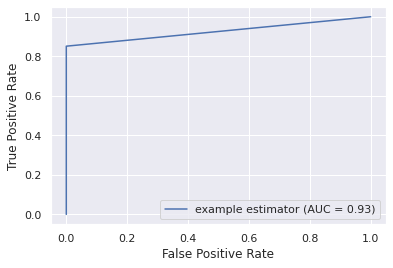

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
y = valid_df[target]
pred = clf.predict(valid_df[predictors])
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

#### Logistic regression on sample

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
df=creditcard.copy()
print(df.shape)
print(df.head(3))

(14708, 10)
   Class    Time   Amount  feature_1  feature_2  feature_3  feature_4  \
0      0  162183     2.99   0.469860  -0.664254   0.160589   0.157691   
1      0  120967     1.98  -0.623472   0.081326   0.543172   0.109356   
2      0   26484  1937.66   1.457844  -0.899347  -6.059393  -1.784000   

   feature_5  feature_6  feature_7  
0   0.818296  -0.471390   0.741141  
1   1.248131        NaN  -0.838932  
2   0.484257  -4.171672   1.195815  


<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Size 100 Sample Distribution')

Text(0.5, 0, 'Target Class Label')

Text(0, 0.5, 'Count of Customers')

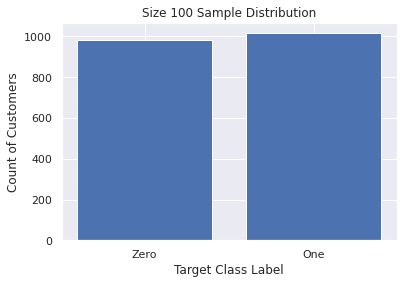

Zero: 984 
One: 1016


In [ ]:
#Credit: https://www.kaggle.com/code/nholloway/comparing-resampling-techniques-and-xgboost/notebook


#### This is for exploration purposes, changing n to very small value to see when model breaks)

#sample = df.sample(n=100) (this is the unbalanced data)

sample = df2.sample(n=2000) ##(this is the oversampled data)



class_1 = len(sample[sample.Class == 1])
class_0 = len(sample[sample.Class== 0])

plt.bar(['Zero', 'One'], [class_0, class_1])
plt.title('Size 100 Sample Distribution')
plt.xlabel('Target Class Label')
plt.ylabel('Count of Customers')
plt.show()
print(f'Zero: {class_0} \nOne: {class_1}')

In [ ]:
sample.describe()

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,Class
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,104.071536,-3.190996,-3.478621,-1.410806,-1.977435,-0.059696,-2.401637,-0.047997,0.508000
std,240.645956,5.710573,4.545001,3.836214,3.355749,0.911333,4.091192,1.078195,0.500061
min,-300.000000,-23.754690,-19.000714,-21.912914,-13.773606,-3.536301,-23.188488,-8.887017,0.000000
25%,1.104123,-5.230672,-6.598639,-1.672611,-3.297325,-0.662959,-3.715670,-0.541325,0.000000
50%,18.011761,-0.557319,-1.142390,-0.398558,-0.641126,-0.096910,-0.572257,-0.010057,1.000000
75%,99.990000,0.199402,0.074624,0.475922,0.323097,0.517573,0.000000,0.480003,1.000000
max,3974.580000,6.729028,5.126543,7.446850,3.917976,3.417591,8.542921,5.618021,1.000000


In [ ]:
sample['counter'] = 1
sample.head()
TransbyClass = pd.concat([sample.groupby("Class")["counter"].sum(),sample.groupby("Class")["Amount"].sum(),sample.groupby("Class")["Amount"].mean()],axis=1)
TransbyClass.columns = ["Frequency", "SumAmount","MeanAmount"]
TransbyClass.head()

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,Class,counter
14645,122.68,-5.558067,-6.745561,-1.254924,-4.325132,1.448725,0.000000,1.064222,1,1
13892,24.99,1.381400,-2.101056,-0.928467,1.661547,-0.520456,0.081024,0.783656,0,1
12966,-50.00,0.475300,-1.223350,-1.930540,-1.835214,2.357002,0.000000,-0.471602,0,1
8961,41.00,-0.509883,0.130495,1.643527,0.412061,0.647683,-1.210422,-0.135408,0,1
11612,203.00,0.281864,0.433295,-1.033610,-1.546676,0.330633,0.152141,-0.520760,0,1


,Frequency,SumAmount,MeanAmount
Class,,,
0,984,84332.010000,85.703262
1,1016,123811.062718,121.861282


In [ ]:
y = np.array(sample.Class.tolist())     #classes: 1..fraud, 0..no fraud

In [ ]:
df22 = sample.drop('Class', 1)
df22

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,counter
14645,122.680000,-5.558067,-6.745561,-1.254924,-4.325132,1.448725,0.000000,1.064222,1
13892,24.990000,1.381400,-2.101056,-0.928467,1.661547,-0.520456,0.081024,0.783656,1
12966,-50.000000,0.475300,-1.223350,-1.930540,-1.835214,2.357002,0.000000,-0.471602,1
8961,41.000000,-0.509883,0.130495,1.643527,0.412061,0.647683,-1.210422,-0.135408,1
11612,203.000000,0.281864,0.433295,-1.033610,-1.546676,0.330633,0.152141,-0.520760,1
...,...,...,...,...,...,...,...,...,...
3220,23.680000,-0.133566,-0.816529,-0.225095,1.210140,-1.002098,0.105919,1.404652,1
3574,11.500000,-0.160708,-0.204244,1.361064,-1.511099,-0.357209,0.650754,-0.955736,1
10874,15.180000,-0.872732,0.562401,3.889795,-0.058133,0.109588,1.500987,1.523792,1
12267,49.000000,-0.572682,1.238351,7.045714,-0.478201,-0.102004,-0.094877,0.043442,1


In [ ]:
df22 = df22.drop('Time', 1)     # optional
df22

KeyError: ignored

In [ ]:
df22 = df22.drop('feature_6', 1)     # optional
df22

,Amount,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7,counter
14645,122.680000,-5.558067,-6.745561,-1.254924,-4.325132,1.448725,1.064222,1
13892,24.990000,1.381400,-2.101056,-0.928467,1.661547,-0.520456,0.783656,1
12966,-50.000000,0.475300,-1.223350,-1.930540,-1.835214,2.357002,-0.471602,1
8961,41.000000,-0.509883,0.130495,1.643527,0.412061,0.647683,-0.135408,1
11612,203.000000,0.281864,0.433295,-1.033610,-1.546676,0.330633,-0.520760,1
...,...,...,...,...,...,...,...,...
3220,23.680000,-0.133566,-0.816529,-0.225095,1.210140,-1.002098,1.404652,1
3574,11.500000,-0.160708,-0.204244,1.361064,-1.511099,-0.357209,-0.955736,1
10874,15.180000,-0.872732,0.562401,3.889795,-0.058133,0.109588,1.523792,1
12267,49.000000,-0.572682,1.238351,7.045714,-0.478201,-0.102004,0.043442,1


In [ ]:
df22 = df22.drop('Amount', 1)     # optional
df22

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7,counter
14645,-5.558067,-6.745561,-1.254924,-4.325132,1.448725,1.064222,1
13892,1.381400,-2.101056,-0.928467,1.661547,-0.520456,0.783656,1
12966,0.475300,-1.223350,-1.930540,-1.835214,2.357002,-0.471602,1
8961,-0.509883,0.130495,1.643527,0.412061,0.647683,-0.135408,1
11612,0.281864,0.433295,-1.033610,-1.546676,0.330633,-0.520760,1
...,...,...,...,...,...,...,...
3220,-0.133566,-0.816529,-0.225095,1.210140,-1.002098,1.404652,1
3574,-0.160708,-0.204244,1.361064,-1.511099,-0.357209,-0.955736,1
10874,-0.872732,0.562401,3.889795,-0.058133,0.109588,1.523792,1
12267,-0.572682,1.238351,7.045714,-0.478201,-0.102004,0.043442,1


In [ ]:
X = np.array(df22.to_numpy())   # features
X

array([[ -5.55806727,  -6.74556132,  -1.25492417, ...,   1.44872489,
          1.06422216,   1.        ],
       [  1.38140048,  -2.10105567,  -0.92846742, ...,  -0.52045635,
          0.7836561 ,   1.        ],
       [  0.47530031,  -1.2233504 ,  -1.93053952, ...,   2.35700168,
         -0.4716023 ,   1.        ],
       ...,
       [ -0.87273162,   0.56240099,   3.88979505, ...,   0.10958756,
          1.52379175,   1.        ],
       [ -0.57268242,   1.23835124,   7.04571369, ...,  -0.10200361,
          0.04344203,   1.        ],
       [-13.75266213,  -8.67685922,  -3.27635003, ...,   1.78440672,
         -0.55717519,   1.        ]])

In [ ]:
print("Fraction of frauds: {:.5f}".format(np.sum(y)))

Fraction of frauds: 1016.00000


In [ ]:
X, X_val, y, y_val = train_test_split(X, y, test_size = 0.5)

In [ ]:
y_val

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,

In [ ]:
print("Fraction of frauds: {:.5f}".format(np.sum(y)))

Fraction of frauds: 492.00000


In [ ]:
lrn = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9)

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

LogisticRegression()

In [ ]:
if lrn.classes_[0] == 1:
    #make sure the ordering of the classes is correct
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

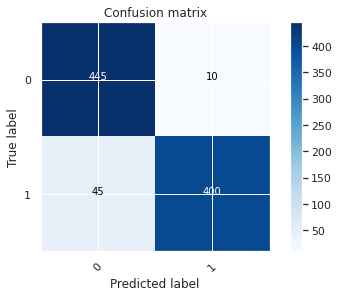

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

plot_confusion_matrix(cm, ['0', '1'], )

In [ ]:
print(cm)

[[445  10]
 [ 45 400]]


In [ ]:
b=445+400+45+10
b

900

In [ ]:
y_pred = lrn.predict(X_test)
print('Predicted Class: %d' % y_pred[1])

Predicted Class: 0


In [ ]:
roc_auc_score(y_test, y_pred)

0.5

In [ ]:
pr, tpr, fpr = show_data(cm, print_res = 1);

Precision =     nan
Recall (TPR) =  0.000
Fallout (FPR) = 0.000e+00


#MRM final assessment


MRM performed full scale validation of the Tier 2, INV-001 "Credit Card Fraud" model. MRM covered all 5 pillars of effective challenge: Model Development Data, Model Conceptual Soundness, Model Technical Soundness, Outcomes Analysis and Ongoing monitoring.
The minor limitations as noted earlier, do not improve the model significantly enough to raise severe issues or concerns.
MRM feels that the model performs well, is not overfitting and can be used in production.

